In [ ]:
# Установка библиотек
!pip install bs4
!pip install openpyxl

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=3df9c53cdb40430ae7466c75435526c99e2b6241c98f5e22628c6581fb55b7d3
  Stored in directory: /root/.cache/pip/wheels/73/2b/cb/099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
Successfully built bs4

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 20.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Импорт библиотек
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython import display

# Парсер для Лента.ру

In [ ]:
class lentaRu_parser:
    def __init__(self):
        pass

    def _get_url(self, param_dict: dict) -> str:
        """
        Возвращает URL для запроса json таблицы со статьями

        url = 'https://lenta.ru/search/v2/process?'\
        + 'from=0&'\                       # Смещение
        + 'size=1000&'\                    # Кол-во статей
        + 'sort=2&'\                       # Сортировка по дате (2), по релевантности (1)
        + 'title_only=0&'\                 # Точная фраза в заголовке
        + 'domain=1&'\                     # ??
        + 'modified%2Cformat=yyyy-MM-dd&'\ # Формат даты
        + 'type=1&'\                       # Материалы. Все материалы (0). Новость (1)
        + 'bloc=4&'\                       # Рубрика. Экономика (4). Все рубрики (0)
        + 'modified%2Cfrom=2020-01-01&'\
        + 'modified%2Cto=2020-11-01&'\
        + 'query='                         # Поисковой запрос
        """
        hasType = int(param_dict["type"]) != 0
        hasBloc = int(param_dict["bloc"]) != 0

        url = (
            "https://lenta.ru/search/v2/process?"
            + "from={}&".format(param_dict["from"])
            + "size={}&".format(param_dict["size"])
            + "sort={}&".format(param_dict["sort"])
            + "title_only={}&".format(param_dict["title_only"])
            + "domain={}&".format(param_dict["domain"])
            + "modified%2Cformat=yyyy-MM-dd&"
            + "type={}&".format(param_dict["type"]) * hasType
            + "bloc={}&".format(param_dict["bloc"]) * hasBloc
            + "modified%2Cfrom={}&".format(param_dict["dateFrom"])
            + "modified%2Cto={}&".format(param_dict["dateTo"])
            + "query={}".format(param_dict["query"])
        )

        return url

    def _get_search_table(self, param_dict: dict) -> pd.DataFrame:
        """
        Возвращает pd.DataFrame со списком статей
        """
        url = self._get_url(param_dict)
        r = rq.get(url)
        search_table = pd.DataFrame(r.json()["matches"])

        return search_table

    def get_articles(
        self, param_dict, time_step=37, save_every=5, save_excel=True
    ) -> pd.DataFrame:
        """
        Функция для скачивания статей интервалами через каждые time_step дней
        Делает сохранение таблицы через каждые save_every * time_step дней

        param_dict: dict
        ### Параметры запроса
        ###### project - раздел поиска, например, rbcnews
        ###### category - категория поиска, например, TopRbcRu_economics
        ###### dateFrom - с даты
        ###### dateTo - по дату
        ###### offset - смещение поисковой выдачи
        ###### limit - лимит статей, максимум 100
        ###### query - поисковой запрос (ключевое слово), например, РБК

        """
        param_copy = param_dict.copy()
        time_step = timedelta(days=time_step)
        dateFrom = datetime.strptime(param_copy["dateFrom"], "%Y-%m-%d")
        dateTo = datetime.strptime(param_copy["dateTo"], "%Y-%m-%d")
        if dateFrom > dateTo:
            raise ValueError("dateFrom should be less than dateTo")

        out = pd.DataFrame()
        save_counter = 0

        while dateFrom <= dateTo:
            param_copy["dateTo"] = (dateFrom + time_step).strftime("%Y-%m-%d")
            if dateFrom + time_step > dateTo:
                param_copy["dateTo"] = dateTo.strftime("%Y-%m-%d")
            print(
                "Parsing articles from "
                + param_copy["dateFrom"]
                + " to "
                + param_copy["dateTo"]
            )
            out = out.append(self._get_search_table(param_copy), ignore_index=True)
            dateFrom += time_step + timedelta(days=1)
            param_copy["dateFrom"] = dateFrom.strftime("%Y-%m-%d")
            save_counter += 1
            if save_counter == save_every:
                display.clear_output(wait=True)
                out.to_excel("/tmp/checkpoint_table.xlsx")
                print("Checkpoint saved!")
                save_counter = 0

        if save_excel:
            out.to_excel(
                "lenta_{}_{}.xlsx".format(param_dict["dateFrom"], param_dict["dateTo"])
            )
        print("Finish")

        return out

Лента.ру

-
query - поисковой запрос (ключевое слово)

- offset - cмещение поисковой выдачи (от 0 до size)

- size - количество статей. Ограничено время запроса, точного лимита нет. 1000 работает почти всегда

- sort - сортировка по дате: (2) - по убыванию, (3) - по возрастанию; по релевантности (1)

- title_only - точная фраза в заголовке (1)

- domain - ?

- material - материалы: Все материалы (0). Новость (1). ["0", "1", "2", "3", "4", ...]

- block - рубрика: Экономика (4). Все рубрики (0). ["0", "1", "2", "3", "4", ...]

- dateFrom - с даты

- dateTo - по дату

In [ ]:
# Задаем тут параметры
use_parser = "LentaRu"

query = ""
offset = 0
size = 1000
sort = "3"
title_only = "0"
domain = "1"
material = "0"
bloc = "0"
dateFrom = "2020-01-01"
dateTo = "2023-11-01"

if use_parser == "LentaRu":
    param_dict = {
        "query": query,
        "from": str(offset),
        "size": str(size),
        "dateFrom": dateFrom,
        "dateTo": dateTo,
        "sort": sort,
        "title_only": title_only,
        "type": material,
        "bloc": bloc,
        "domain": domain,
    }

print(use_parser, "- param_dict:", param_dict)

LentaRu - param_dict: {'query': '', 'from': '0', 'size': '1000', 'dateFrom': '2020-01-01', 'dateTo': '2023-11-01', 'sort': '3', 'title_only': '0', 'type': '0', 'bloc': '0', 'domain': '1'}


In [ ]:
# Тоже будем собирать итеративно, правда можно ставить time_step побольше, т.к.
# больше лимит на запрос статей. И Работает быстрее :)
assert use_parser == "LentaRu"
parser = lentaRu_parser()
tbl = parser.get_articles(
    param_dict=param_dict, time_step=37, save_every=5, save_excel=True
)
print(len(tbl.index))

Checkpoint saved!
Parsing articles from 2023-08-23 to 2023-09-29
Parsing articles from 2023-09-30 to 2023-11-01
Finish
37000


In [ ]:
tbl.to_csv('file.csv')

In [ ]:
df = pd.read_csv('file.csv')

In [ ]:
df.head()

Unnamed: 0   docid                                           url  \
0           0  943560   https://lenta.ru/news/2020/01/01/trudovaya/   
1           1  943835  https://lenta.ru/news/2020/01/01/zavorotnuk/   
2           2  943747         https://lenta.ru/news/2020/01/01/org/   
3           3  943836       https://lenta.ru/news/2020/01/01/sleep/   
4           4  943634    https://lenta.ru/news/2020/01/01/theaters/   

                                               title    modified  lastmodtime  \
0         В России ввели электронные трудовые книжки  1577836860   1577866854   
1  Заворотнюк поблагодарила поклонников за поддержку  1577838422   1577838422   
2      В России утвердили стандарты органической еды  1577838649   1577838649   
3              Объяснена опасность неправильного сна  1577839980   1577964161   
4            Российские театры освободили от налогов  1577840882   1577840883   

   type  domain  status  part  bloc    tags  \
0     1       1       0     0     1     [2]   
1     1       1       0     0     6    [18]   
2     1       1       0     0     4  [7, 8]   
3     1       1       0     0     5    [16]   
4     1       1       0     0     4     [7]   

                                           image_url     pubdate  \
0  https://icdn.lenta.ru/images/2019/12/30/15/201...  1577836860   
1  https://icdn.lenta.ru/images/2020/01/01/03/202...  1577838422   
2  https://icdn.lenta.ru/images/2019/12/31/13/201...  1577838649   
3  https://icdn.lenta.ru/images/2020/01/01/03/202...  1577839980   
4  https://icdn.lenta.ru/images/2019/12/30/20/201...  1577840882   

                                                text  \
0  Фото:  Юрий Мартьянов /« Коммерсантъ» В России...   
1  Фото: Анатолий Ломохов / Globallookpress.com П...   
2  Фото: Rupert Oberhäuser / Globallookpress.com ...   
3  Фото: Vladislav Muslakov / Unsplash Спящие бол...   
4  Фото: Константин Кокошкин / «Коммерсантъ» Росс...   

                                            rightcol  \
0  Работодатели смогут передавать сведения в Пенс...   
1  Соответствующая запись появилась в Instagram-а...   
2          Вступил в силу принятый в 2018 году закон   
3  Спящие слишком мало или слишком много более по...   
4  Обнулить базу удастся при условии строго следо...   

                                             snippet  
0  Фото:  Юрий Мартьянов /« Коммерсантъ» В ... кн...  
1  Фото: Анатолий Ломохов / Globallookpress.... г...  
2  Фото: Rupert Oberhäuser / ... для производител...  
3  Фото: Vladislav Muslakov / Unsplash ..., чем т...  
4  Фото: Константин Кокошкин / «Коммерсантъ»... п...

In [ ]:
# Изначально данных в датасете
df.shape

(37000, 17)

In [ ]:
# Выводим строки со значение текста None
df[df["text"].isna()]

Unnamed: 0    docid                                                url  \
26             26   943854  https://lenta.ru/sport/2020/01/01/football-liv...   
100           100   943933  https://lenta.ru/sport/2020/01/02/hockey-bosto...   
101           101   943934  https://lenta.ru/sport/2020/01/02/football-roc...   
102           102   943932  https://lenta.ru/sport/2020/01/02/basketball-o...   
201           201   944036  https://lenta.ru/sport/2020/01/03/basketball-t...   
...           ...      ...                                                ...   
36813       36813  1503168   https://lenta.ru/extlink/2023/10/02/ugon_likvid/   
36860       36860  1502988          https://lenta.ru/extlink/2023/10/02/cena/   
36954       36954  1503166  https://lenta.ru/extlink/2023/10/02/nemolievab...   
36969       36969  1503310       https://lenta.ru/extlink/2023/10/02/zavtrak/   
36998       36998  1492010  https://lenta.ru/extlink/2023/09/11/dohodniye_...   

                                                   title    modified  \
26     Англия - Премьер-лига - 21-й тур - Ливерпуль-Ш...  1577870100   
100    НХЛ - регулярный чемпионат - Бостон Брюинз-Кол...  1577949240   
101    Кубок Англии - 1/32 финала - Рочдейл-Ньюкасл Ю...  1577949240   
102    Евролига - Регулярный чемпионат. 17-й тур - Ол...  1577949240   
201    Евролига - Регулярный чемпионат. 17-й тур - ЦС...  1578036060   
...                                                  ...         ...   
36813  На российском ТВ вышел сюжет об угонщике верто...  1696252467   
36860      Стала известна средняя цена квартиры в Москве  1696257120   
36954  86-летняя Немоляева раскрыла правду о своих за...  1696267869   
36969               Названы худшие продукты для завтрака  1696270382   
36998                                     Доходные дома.  1696280726   

       lastmodtime  type  domain  status  part  bloc   tags  \
26      1577870119    17       1       0     0     8  [236]   
100     1577949347    17       1       0     0     8  [183]   
101     1577949368    17       1       0     0     8  [236]   
102     1577949309    17       1       0     0     8   [36]   
201     1578036087    17       1       0     0     8   [33]   
...            ...   ...     ...     ...   ...   ...    ...   
36813   1696252925    15       1       0     1     1    [2]   
36860   1696257237    15       1       0     0     0     []   
36954   1696267869    15       1       0     0     0     []   
36969   1696311491    15       1       0     0     0     []   
36998   1696280726    15       1       0     1     0     []   

                                               image_url     pubdate text  \
26                                                   NaN  1577870100  NaN   
100                                                  NaN  1577949240  NaN   
101                                                  NaN  1577949240  NaN   
102                                                  NaN  1577949240  NaN   
201                                                  NaN  1578036060  NaN   
...                                                  ...         ...  ...   
36813  https://icdn.lenta.ru/images/2023/10/02/16/202...  1696252467  NaN   
36860  https://icdn.lenta.ru/images/2023/10/02/12/202...  1696257120  NaN   
36954  https://icdn.lenta.ru/images/2023/10/02/16/202...  1696267869  NaN   
36969  https://icdn.lenta.ru/images/2023/10/03/08/202...  1696270382  NaN   
36998  https://icdn.lenta.ru/images/2023/10/02/17/202...  1696280726  NaN   

                                                rightcol snippet  
26     Англия - Премьер-лига - 21-й тур - Ливерпуль-Ш...     NaN  
100    НХЛ - регулярный чемпионат - Бостон Брюинз-Кол...     NaN  
101    Кубок Англии - 1/32 финала - Рочдейл-Ньюкасл Ю...     NaN  
102    Евролига - Регулярный чемпионат. 17-й тур - Ол...     NaN  
201    Евролига - Регулярный чемпионат. 17-й тур - ЦС...     NaN  
...                                                  ...     ...  
36813  Бойцы спецн

In [ ]:
# Удаляем статьи со None
df = df.dropna()

In [ ]:
# Форма датасета
df.shape

(36214, 17)

In [ ]:
# Теперь проверим, есть ли дупликаты.
duplicateRows = df[df.duplicated(["url"])]
duplicateRows

Empty DataFrame
Columns: [Unnamed: 0, docid, url, title, modified, lastmodtime, type, domain, status, part, bloc, tags, image_url, pubdate, text, rightcol, snippet]
Index: []

In [ ]:
# Посмотрим сколько всего у нас bloc (рубрик)
print(f"shape df{df.shape}")
print(f"unique categories {df['bloc'].unique()}")

shape df(36214, 17)
unique categories [ 1  6  4  5  2  7  8 37  3 47  9 48 12 49  0 53 86 87 40]


In [ ]:
# Посчитаем количество каждой рубрики
df.groupby("bloc").agg({"docid": "count"}).sort_values(by="docid", ascending=False)

docid
bloc       
1      7264
2      5526
3      3567
4      3523
8      2180
37     2099
5      1900
7      1655
48     1485
12     1471
47     1390
6      1373
9      1355
86      466
87      465
53      297
49      172
0        25
40        1

Стало известно о состоянии пострадавших при нападении на пост ДПС в Ингушетии

In [ ]:
# Удостоверимся, что рубрики под номерами [1, 2, 3, 4, 5, 8, 37] соответсвуют следующим рубрикам [Россия, Мир, Бывший СССР, Экономика, Наука и техника, Силовые структуры]
df[df['bloc'] == 37].url

30                 https://lenta.ru/news/2020/01/01/magas/
31               https://lenta.ru/news/2020/01/01/sarapul/
48                   https://lenta.ru/news/2020/01/01/msc/
50             https://lenta.ru/news/2020/01/01/zastrelil/
51           https://lenta.ru/news/2020/01/01/podrobnosti/
                               ...                        
36955            https://lenta.ru/news/2023/10/02/mscross/
36959               https://lenta.ru/news/2023/10/02/nark/
36961    https://lenta.ru/news/2023/10/02/taxiiiiiiiitula/
36965      https://lenta.ru/news/2023/10/02/doooollllaaar/
36984              https://lenta.ru/news/2023/10/02/vitch/
Name: url, Length: 2099, dtype: object

In [ ]:
df.loc[df.bloc.isin([1, 2, 3, 4, 5, 8, 37])].groupby("bloc").agg({"docid": "count"})

docid
bloc       
1      7264
2      5526
3      3567
4      3523
5      1900
8      2180
37     2099

In [ ]:
# Создадим копию датафрейма, чтобы не испортить исходный датафрейм
df_copy = df.loc[df['bloc'].isin([1, 2, 3, 4, 5, 8, 37])].copy()

In [ ]:
df_copy.shape

(26059, 17)

In [ ]:
df_copy.head(2)

Unnamed: 0   docid                                          url  \
0           0  943560  https://lenta.ru/news/2020/01/01/trudovaya/   
2           2  943747        https://lenta.ru/news/2020/01/01/org/   

                                           title    modified  lastmodtime  \
0     В России ввели электронные трудовые книжки  1577836860   1577866854   
2  В России утвердили стандарты органической еды  1577838649   1577838649   

   type  domain  status  part  bloc    tags  \
0     1       1       0     0     1     [2]   
2     1       1       0     0     4  [7, 8]   

                                           image_url     pubdate  \
0  https://icdn.lenta.ru/images/2019/12/30/15/201...  1577836860   
2  https://icdn.lenta.ru/images/2019/12/31/13/201...  1577838649   

                                                text  \
0  Фото:  Юрий Мартьянов /« Коммерсантъ» В России...   
2  Фото: Rupert Oberhäuser / Globallookpress.com ...   

                                            rightcol  \
0  Работодатели смогут передавать сведения в Пенс...   
2          Вступил в силу принятый в 2018 году закон   

                                             snippet  
0  Фото:  Юрий Мартьянов /« Коммерсантъ» В ... кн...  
2  Фото: Rupert Oberhäuser / ... для производител...

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26059 entries, 0 to 36999
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   26059 non-null  int64 
 1   docid        26059 non-null  int64 
 2   url          26059 non-null  object
 3   title        26059 non-null  object
 4   modified     26059 non-null  int64 
 5   lastmodtime  26059 non-null  int64 
 6   type         26059 non-null  int64 
 7   domain       26059 non-null  int64 
 8   status       26059 non-null  int64 
 9   part         26059 non-null  int64 
 10  bloc         26059 non-null  int64 
 11  tags         26059 non-null  object
 12  image_url    26059 non-null  object
 13  pubdate      26059 non-null  int64 
 14  text         26059 non-null  object
 15  rightcol     26059 non-null  object
 16  snippet      26059 non-null  object
dtypes: int64(10), object(7)
memory usage: 3.6+ MB


In [ ]:
# Удалим ненужные столбцы
df_copy.drop(
    columns=[
        "docid",
        "modified",
        "lastmodtime",
        "type",
        "domain",
        "status",
        "part",
        "tags",
        "image_url",
        "rightcol",
        "Unnamed: 0"
    ],
    inplace=True,
)

In [ ]:
# Создадим словарь, с помощью которого преобразуем цифры из нашего столбца 'bloc' в конкретное название рубрики
news_category = {1: "Россия", 2: "Мир",
                 3: "Бывший СССР", 4: "Экономика",
                 37: "Силовые структуры", 8: "Спорт",
                 5: "Наука и техника"}

df_copy['bloc'] = df_copy['bloc'].map(news_category)

In [ ]:
# Заменем названия колонок на более читаемое
df_copy.rename(
    columns={"text": "content", "snippet": "subtitle", "bloc": "topic", "pubdate": "datetime"}, inplace=True
)

# Переведем timestamp в стринг с датой и временем
df_copy["datetime"] = df_copy["datetime"].apply(lambda x: str(datetime.fromtimestamp(x)))


In [ ]:
# Переведем столбец "datetime" в объекты datetime
df_copy["datetime"] = pd.to_datetime(df_copy["datetime"])

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26059 entries, 0 to 36999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   url       26059 non-null  object        
 1   title     26059 non-null  object        
 2   topic     26059 non-null  object        
 3   datetime  26059 non-null  datetime64[ns]
 4   content   26059 non-null  object        
 5   subtitle  26059 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.4+ MB


In [ ]:
df_copy.shape

(26059, 6)

In [ ]:
df_copy.to_csv('df_preprocessed.csv')

In [ ]:
df_copy.head(5)

url  \
0  https://lenta.ru/news/2020/01/01/trudovaya/   
2        https://lenta.ru/news/2020/01/01/org/   
3      https://lenta.ru/news/2020/01/01/sleep/   
4   https://lenta.ru/news/2020/01/01/theaters/   
5   https://lenta.ru/news/2020/01/01/utilsbor/   

                                           title            topic  \
0     В России ввели электронные трудовые книжки           Россия   
2  В России утвердили стандарты органической еды        Экономика   
3          Объяснена опасность неправильного сна  Наука и техника   
4        Российские театры освободили от налогов        Экономика   
5                 В России подорожают автомобили           Россия   

             datetime                                            content  \
0 2020-01-01 00:01:00  Фото:  Юрий Мартьянов /« Коммерсантъ» В России...   
2 2020-01-01 00:30:49  Фото: Rupert Oberhäuser / Globallookpress.com ...   
3 2020-01-01 00:53:00  Фото: Vladislav Muslakov / Unsplash Спящие бол...   
4 2020-01-01 01:08:02  Фото: Константин Кокошкин / «Коммерсантъ» Росс...   
5 2020-01-01 01:44:50  Фото: Александр Коряков / «Коммерсантъ» Автомо...   

                                            subtitle  
0  Фото:  Юрий Мартьянов /« Коммерсантъ» В ... кн...  
2  Фото: Rupert Oberhäuser / ... для производител...  
3  Фото: Vladislav Muslakov / Unsplash ..., чем т...  
4  Фото: Константин Кокошкин / «Коммерсантъ»... п...  
5  Фото: Александр Коряков / «Коммерсантъ» ... вы...

# Первичный анализ данных

In [ ]:
pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.4/460.4 kB 18.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_pro = pd.read_csv('df_preprocessed.csv')

In [ ]:
# Размер каждой категории
df_pro['topic'].value_counts()

Россия               7264
Мир                  5526
Бывший СССР          3567
Экономика            3523
Спорт                2180
Силовые структуры    2099
Наука и техника      1900
Name: topic, dtype: int64

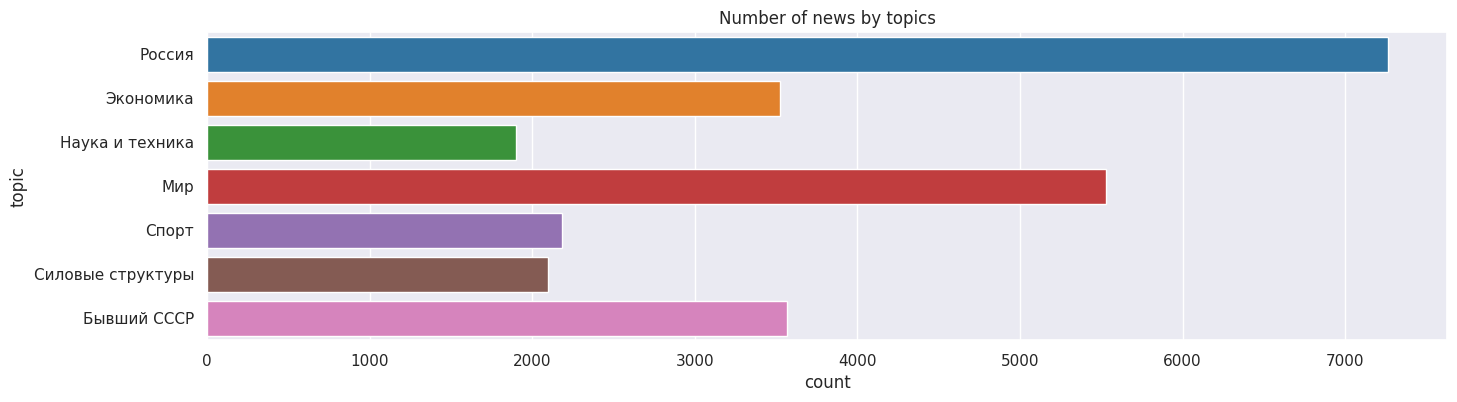

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(y=df_pro["topic"], palette="tab10", ax=ax)
plt.title("Number of news by topics");

Из графика видно, что часть категорий несбалансированы.

In [ ]:
# Создадим новые признаки
df_pro["len_title"] = df_pro["title"].str.len()
df_pro["len_subtitle"] = df_pro["subtitle"].str.len()
df_pro["len_content"] = df_pro["content"].str.len()

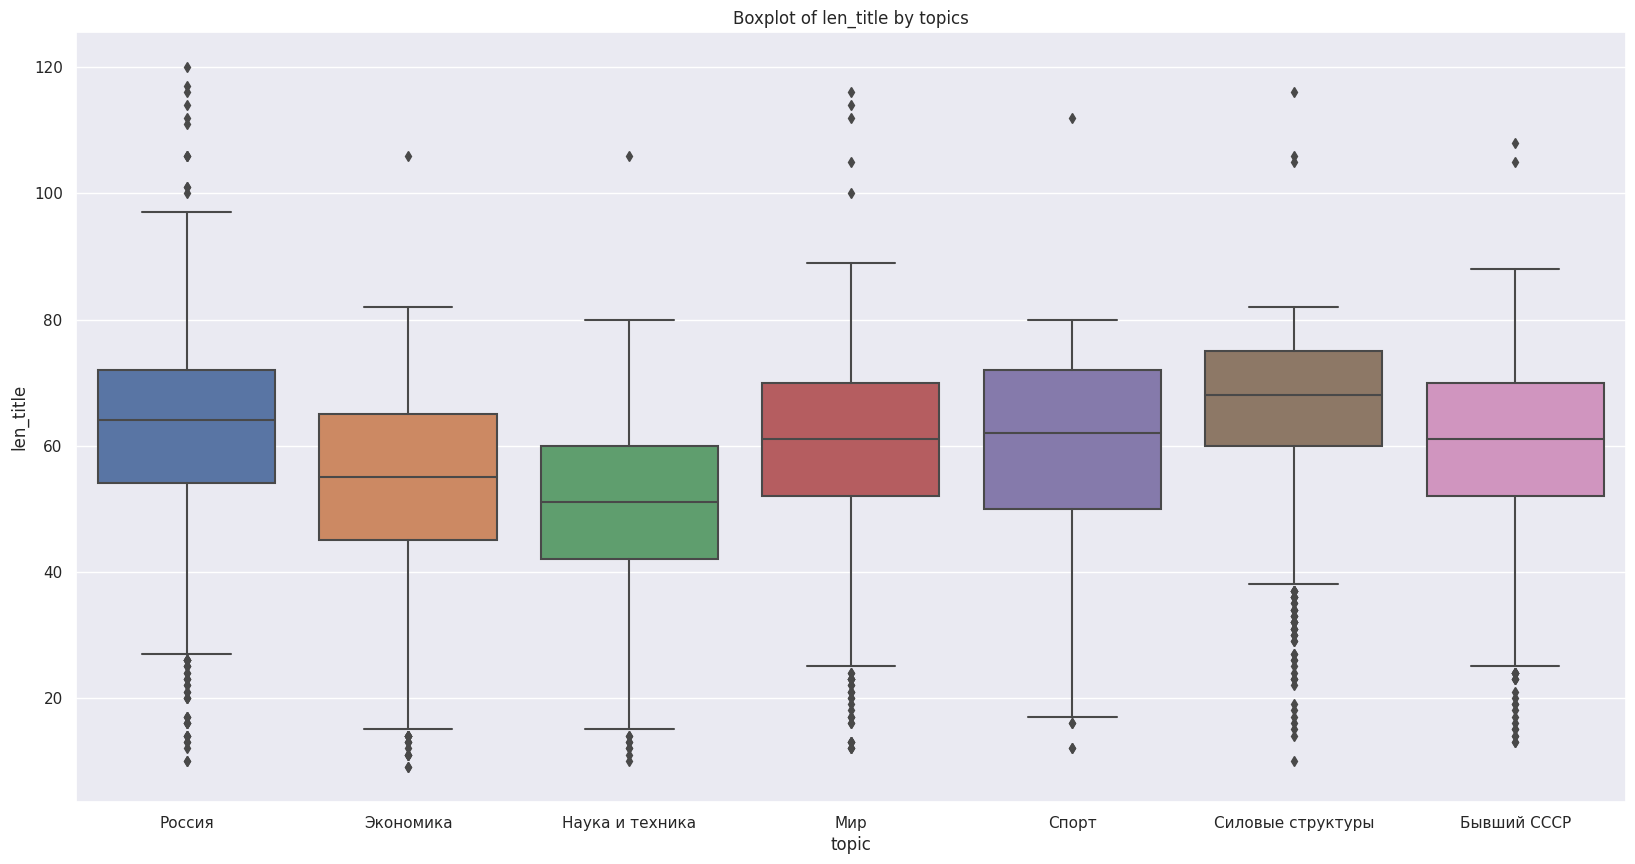

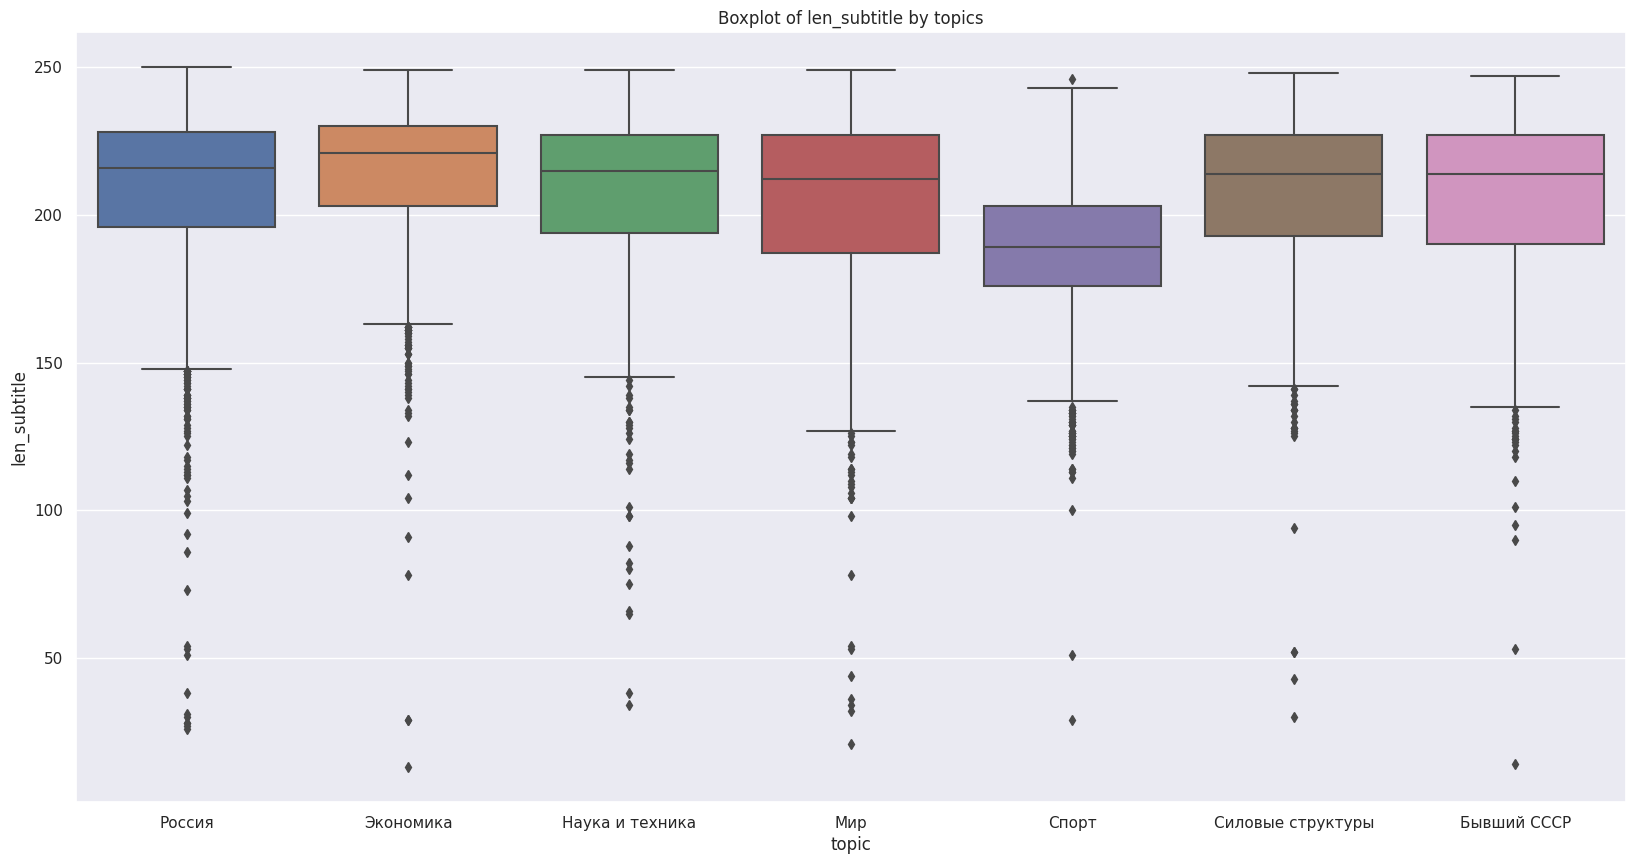

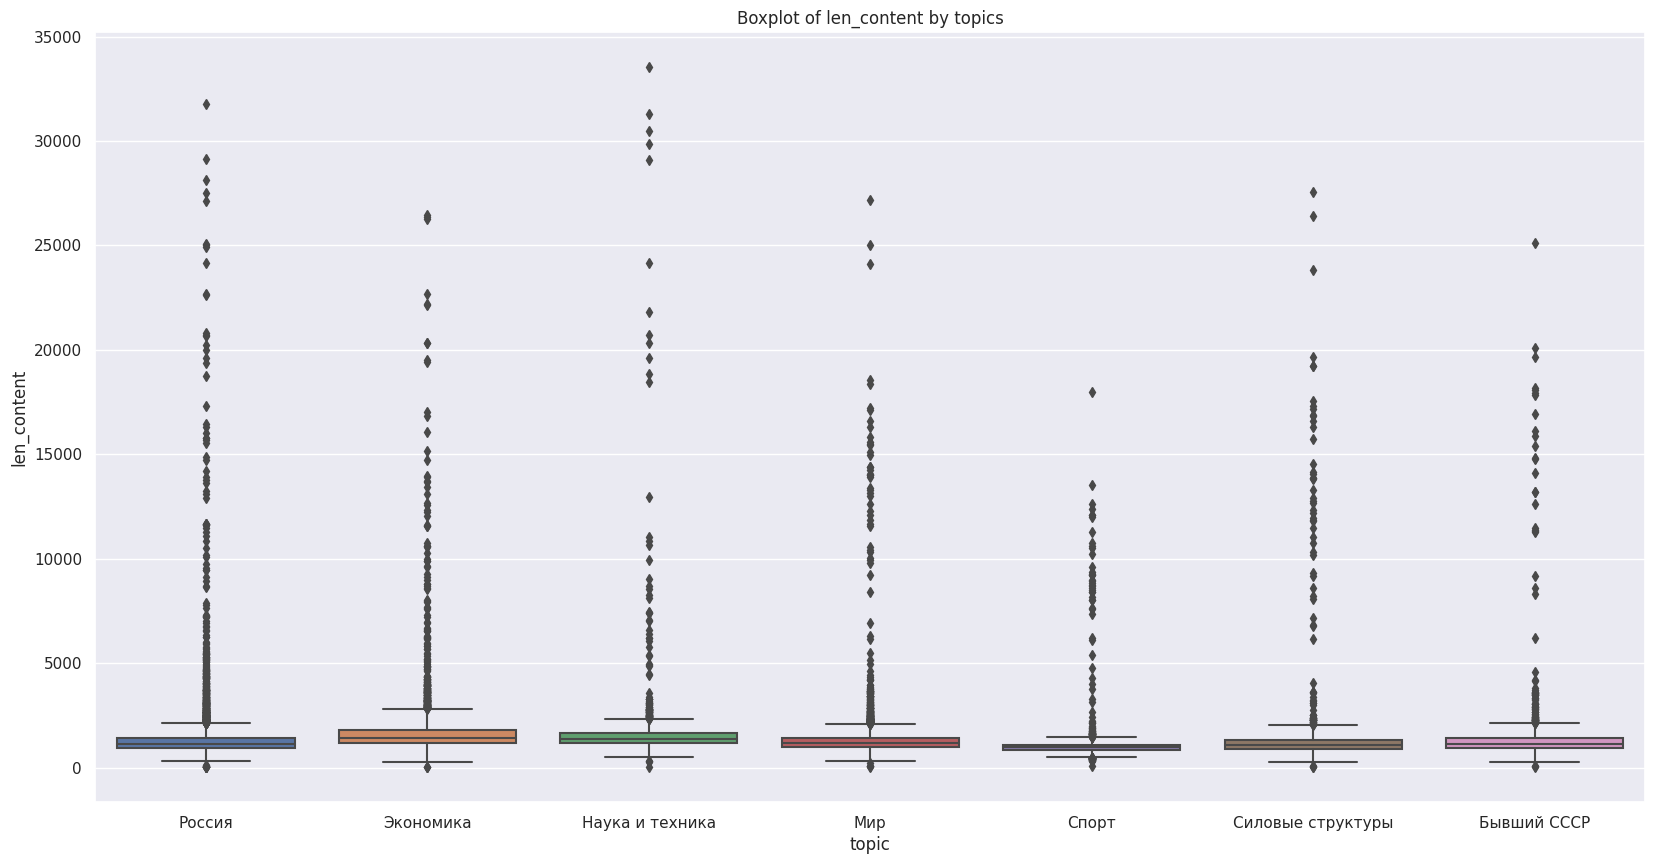

In [ ]:
for col in ["len_title", "len_subtitle", "len_content"]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df_pro, ax=ax)
    plt.title(f"Boxplot of {col} by topics");

Что можно заметить:

В среднем длина заголовка по всем категориям около 55-65 символов
Вступительный подзаголовка в среднем составляет 230 символов.

Во всех параметрах и для всех категорий наблюдается большое количество заметные выбросов в сторону большего количества символов.

In [ ]:
# добавим к нашим признакам год, месяц и день недели.
#Предположим, что у вас есть столбец "datetime" в DataFrame
df_pro["datetime"] = pd.to_datetime(df_pro["datetime"])

# Получение года
df_pro["year"] = df_pro["datetime"].dt.year

# Получение месяца
df_pro["month"] = df_pro["datetime"].dt.month
# Преобразование числового значения дня месяцев в текстовое представление
df_pro["month_name"] = df_pro["datetime"].dt.month_name()

# Получение дня недели (где понедельник - 0, воскресенье - 6)
df_pro["weekday"] = df_pro["datetime"].dt.dayofweek
# Преобразование числового значения дня недели в текстовое представление
df_pro["weekday_name"] = df_pro["datetime"].dt.day_name()

In [ ]:
df_pro.head(3)

url  \
0  https://lenta.ru/news/2020/01/01/trudovaya/   
1        https://lenta.ru/news/2020/01/01/org/   
2      https://lenta.ru/news/2020/01/01/sleep/   

                                           title            topic  \
0     В России ввели электронные трудовые книжки           Россия   
1  В России утвердили стандарты органической еды        Экономика   
2          Объяснена опасность неправильного сна  Наука и техника   

             datetime                                            content  \
0 2020-01-01 00:01:00  Фото:  Юрий Мартьянов /« Коммерсантъ» В России...   
1 2020-01-01 00:30:49  Фото: Rupert Oberhäuser / Globallookpress.com ...   
2 2020-01-01 00:53:00  Фото: Vladislav Muslakov / Unsplash Спящие бол...   

                                            subtitle  len_title  len_subtitle  \
0  Фото:  Юрий Мартьянов /« Коммерсантъ» В ... кн...         42           240   
1  Фото: Rupert Oberhäuser / ... для производител...         45           209   
2  Фото: Vladislav Muslakov / Unsplash ..., чем т...         37           195   

   len_content  year  month  weekday weekday_name month_name  
0          986  2020      1        2    Wednesday    January  
1          878  2020      1        2    Wednesday    January  
2          980  2020      1        2    Wednesday    January

In [ ]:
# Удалим ненужный столбец
df_pro.drop(
    columns=["Unnamed: 0"],
    inplace=True,
)

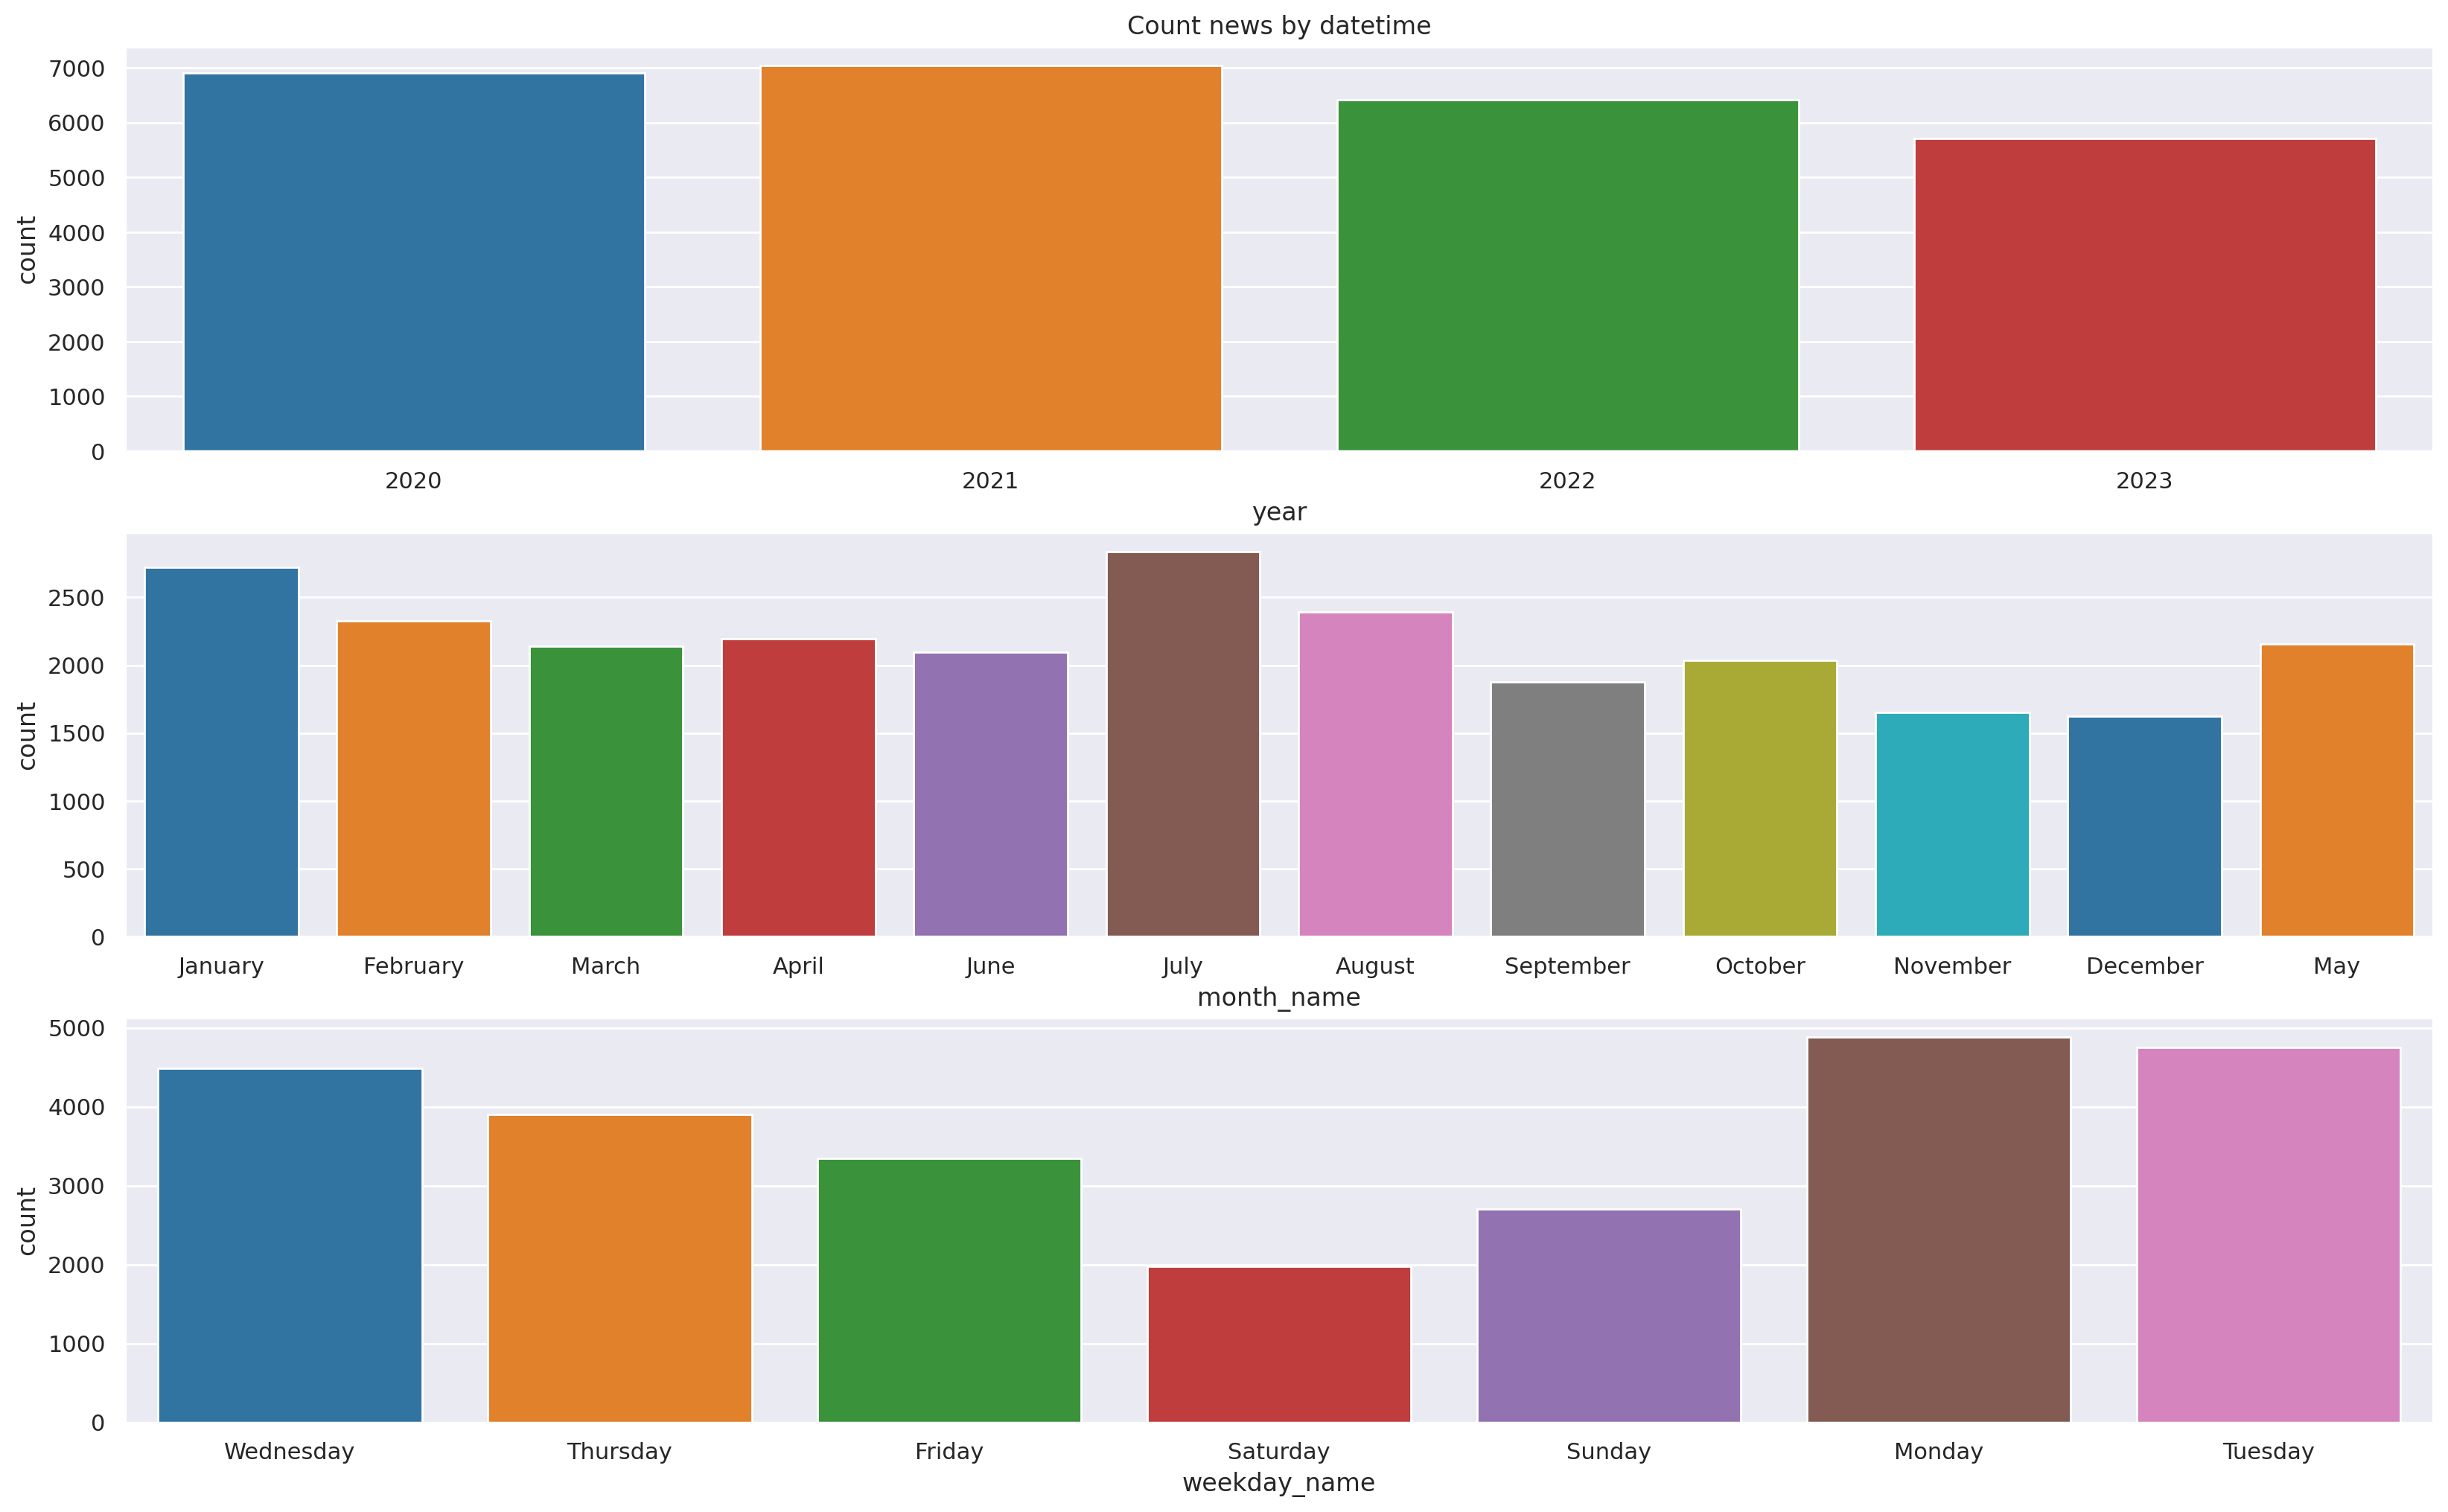

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month_name", "weekday_name"]):
    sns.countplot(
        x=df_pro[col],
        palette="tab10",
        ax=axs[ind]
        # , order=df[col].value_counts(ascending=True).index
    )
axs[0].set_title("Count news by datetime");

Какие выводы можно сделать по графикам ниже:

Все новости относятся к разным годам: с 2020 по 2023. Без пропусков.
Больше всего новостей приходится на 2020 и 2021 года, а также на январь и июль.

В течение недели больше всего новостей в Понедельник, Вторник и Воскресение
Меньше всего новостей в 2023, но это и понятно, год еще не закончился.

Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [ ]:
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "комментарий",
        "английский",
        "язык",
    ]
)

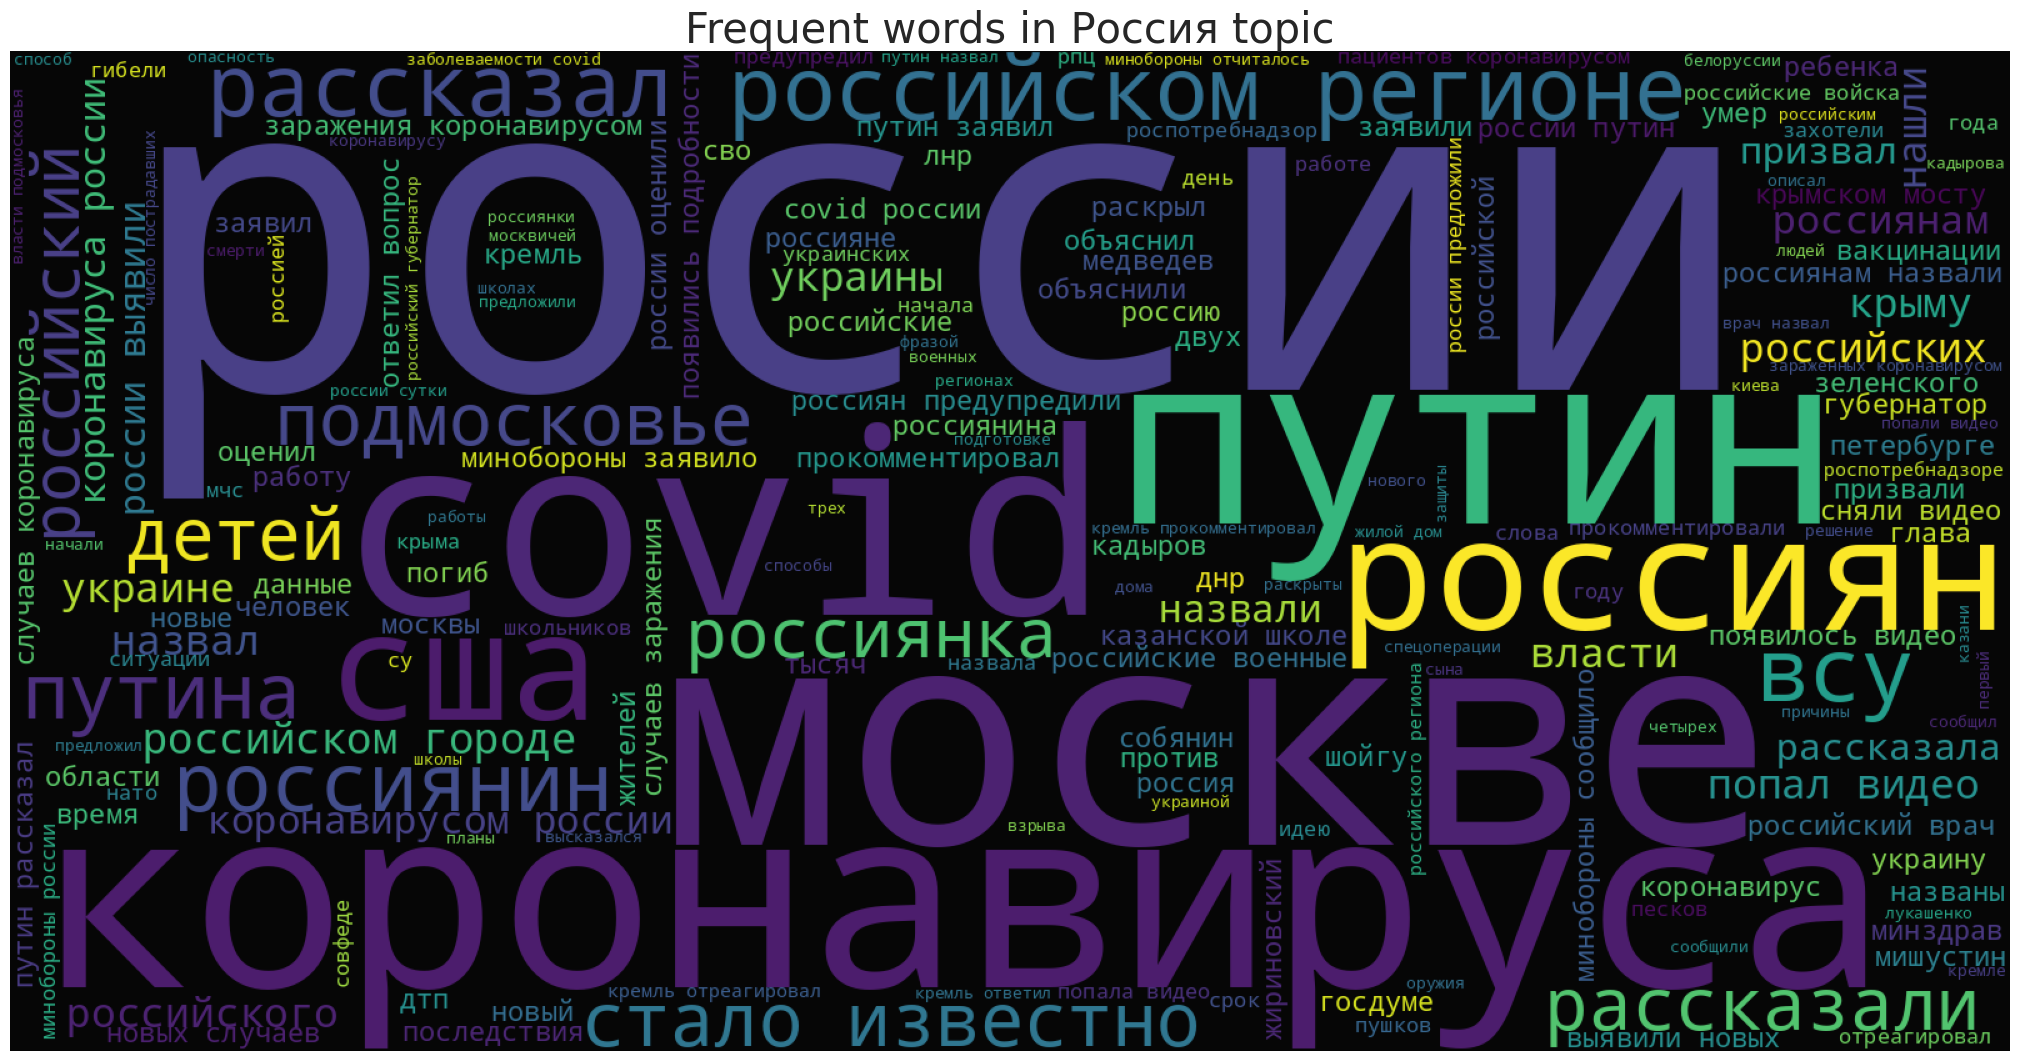

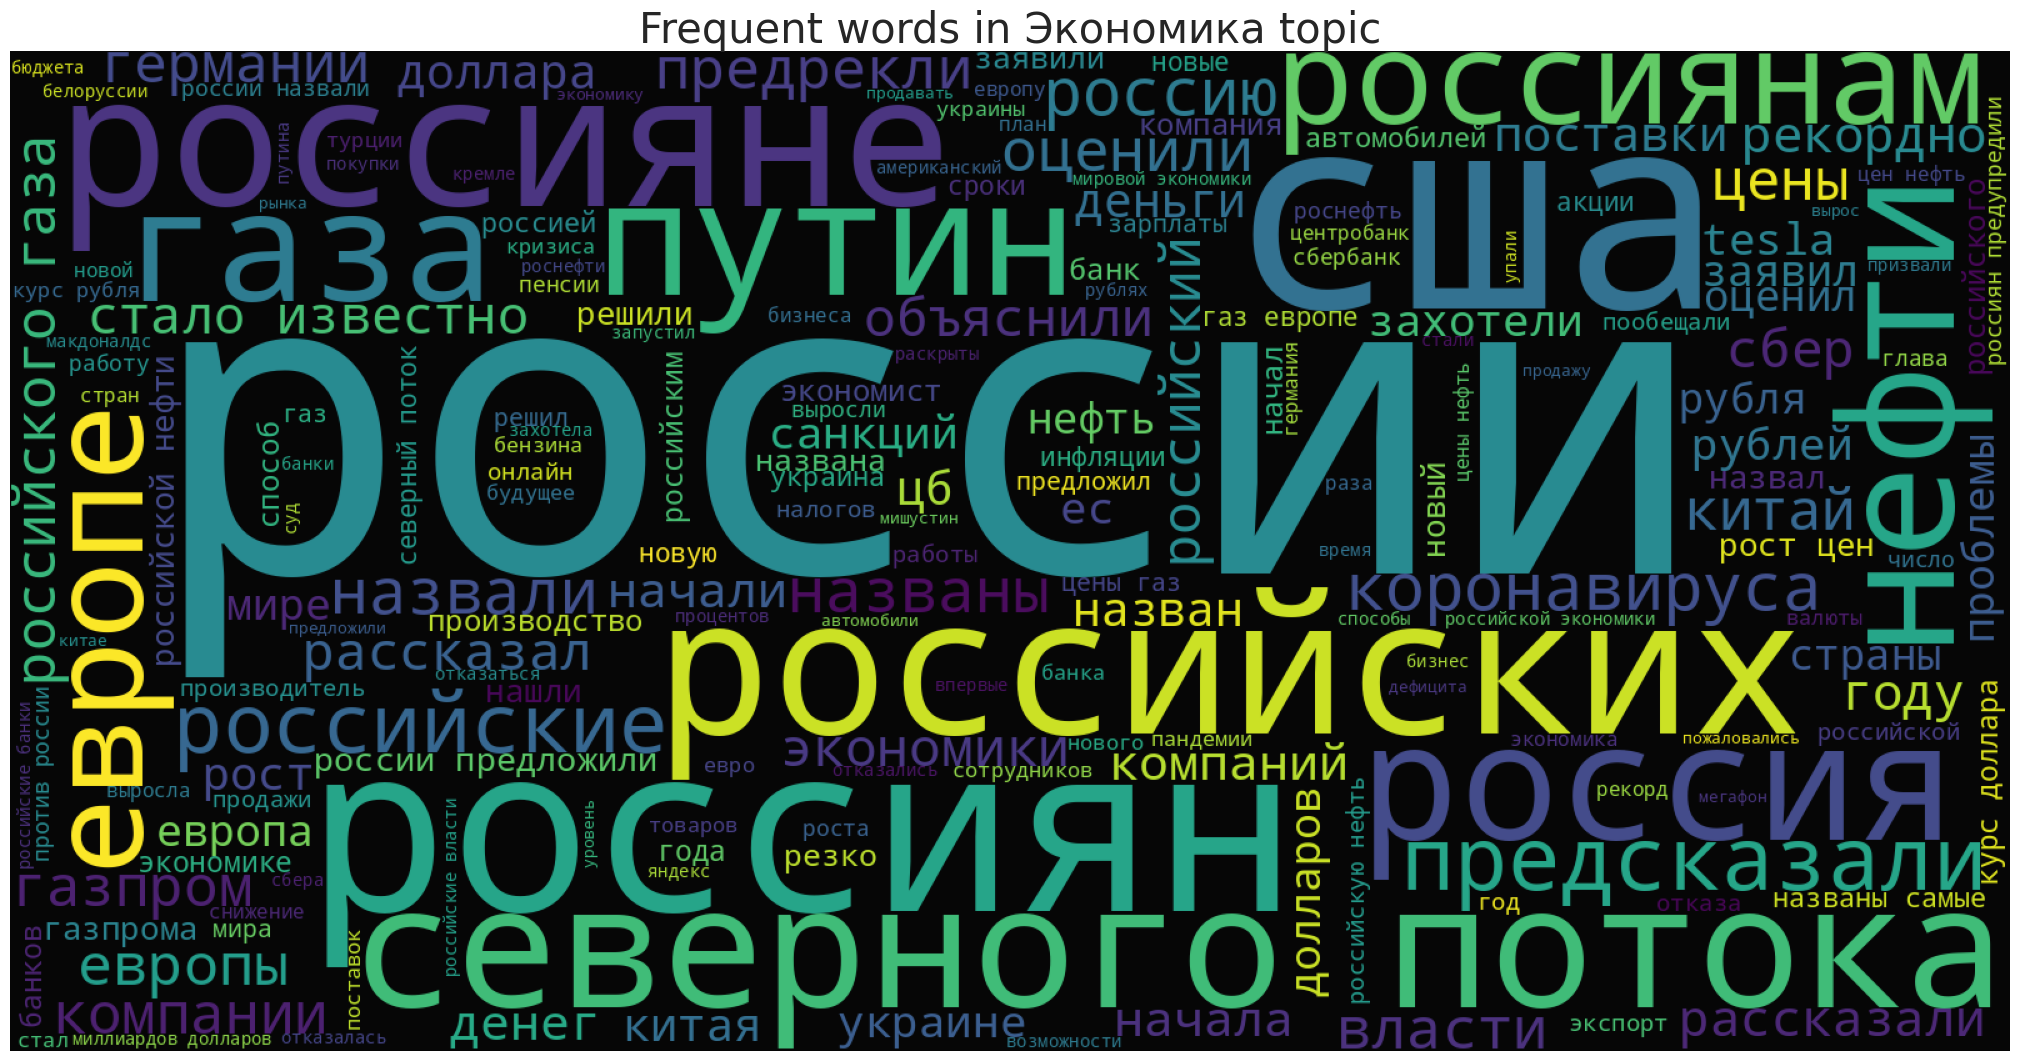

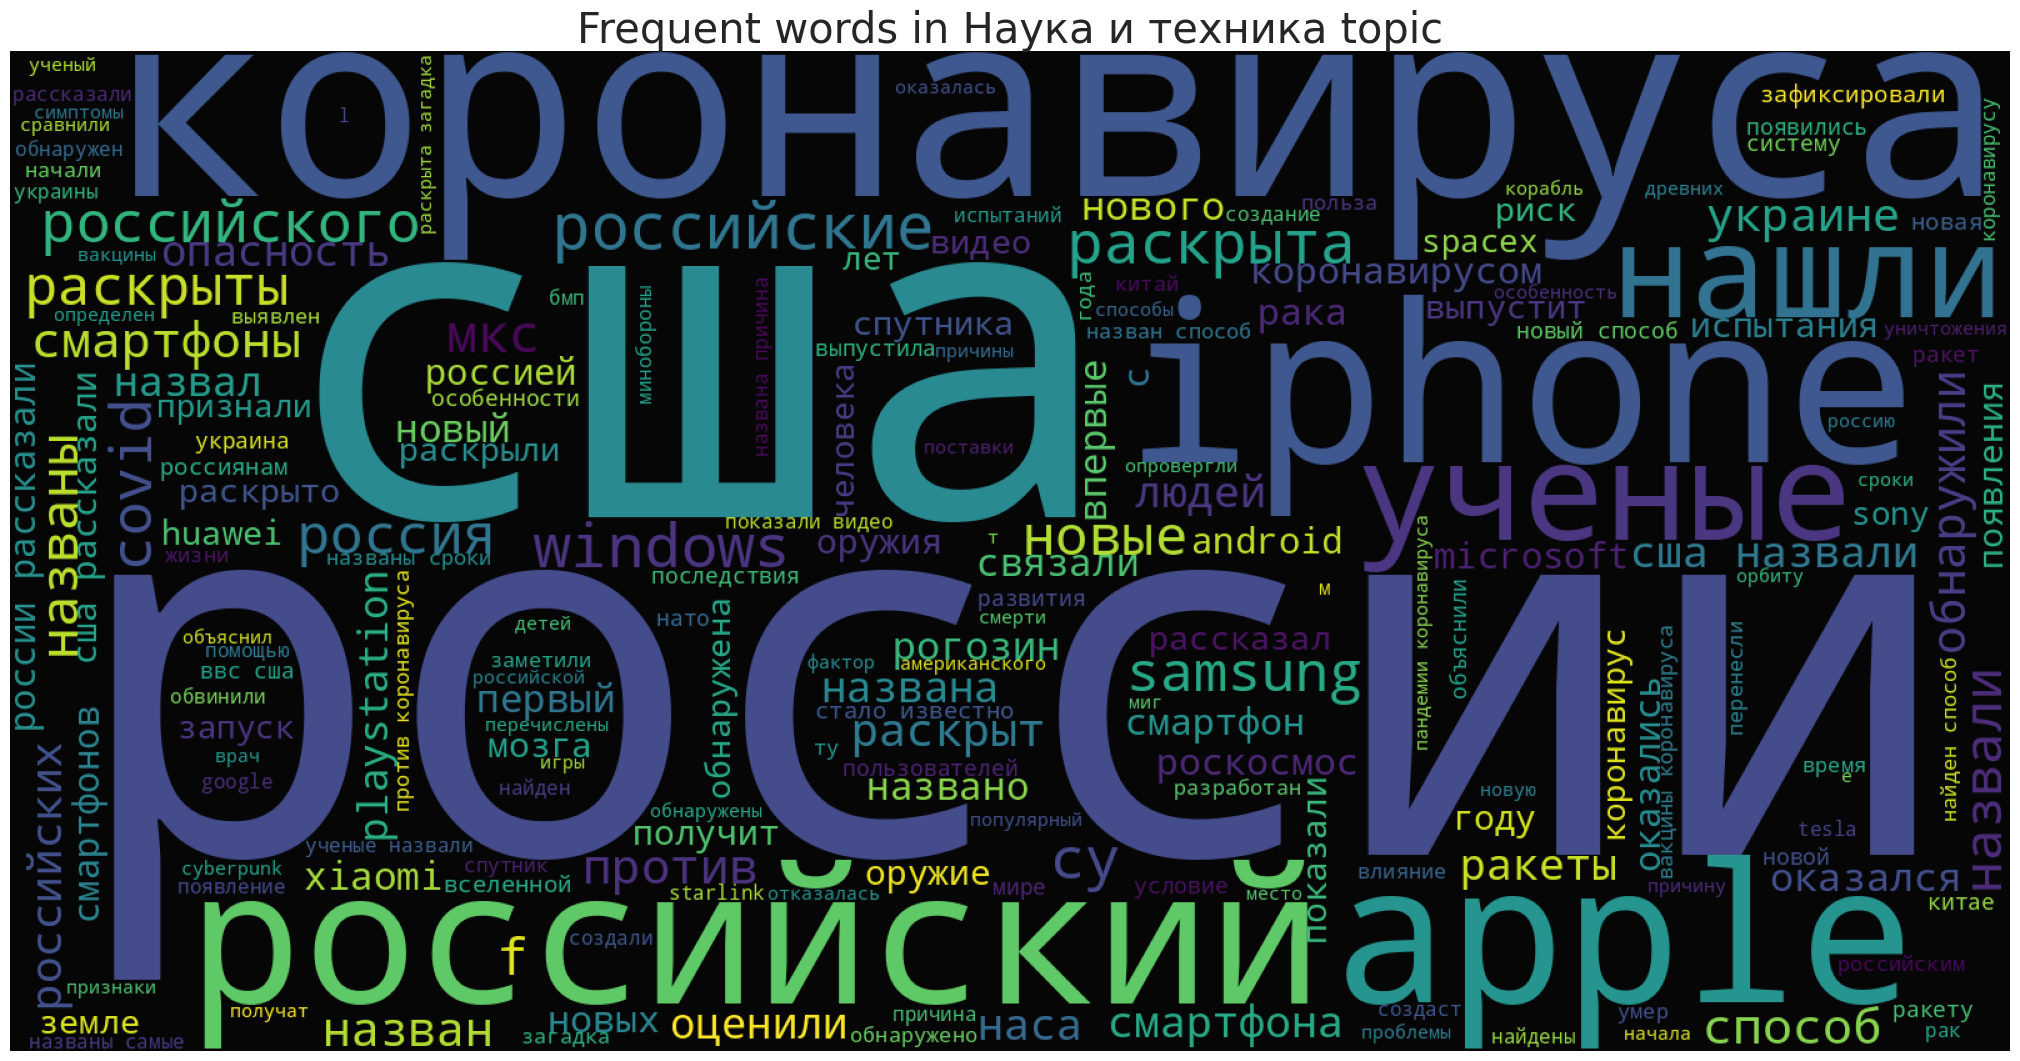

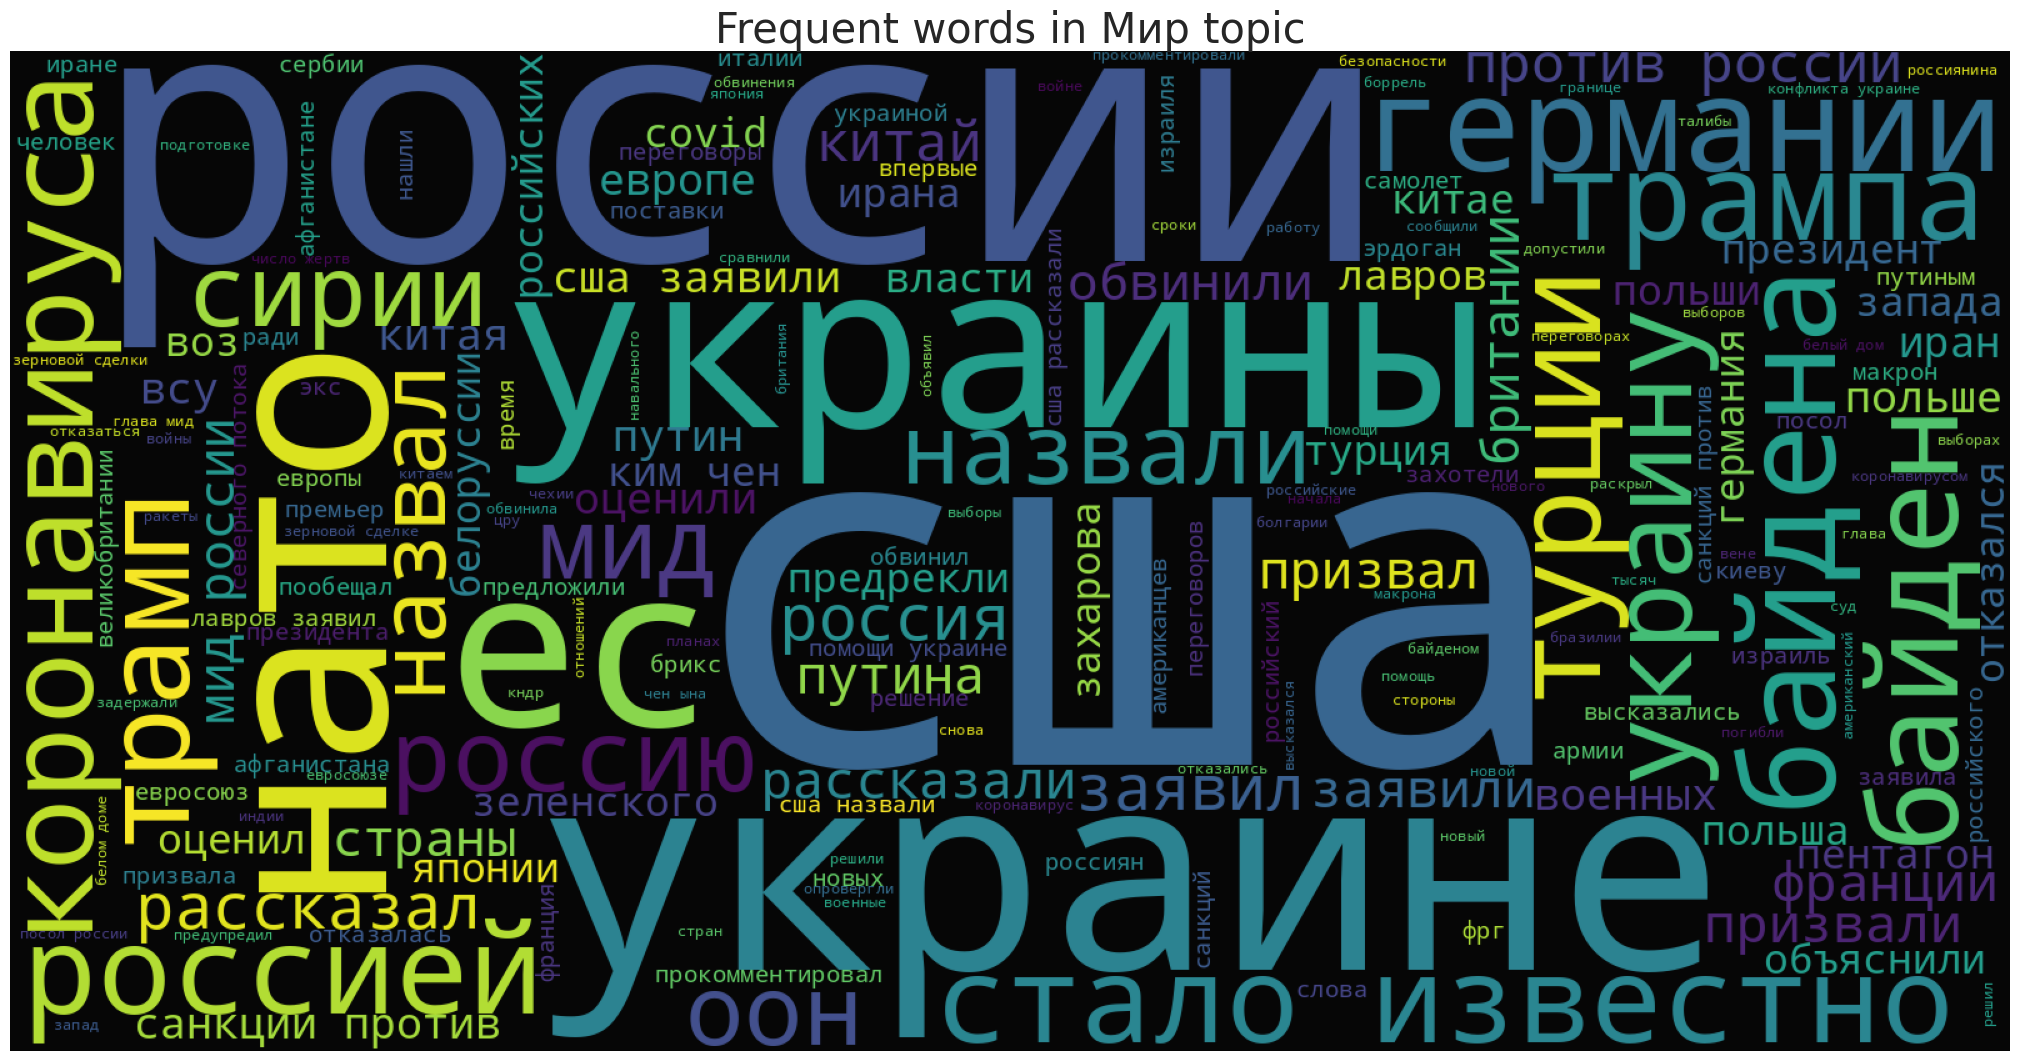

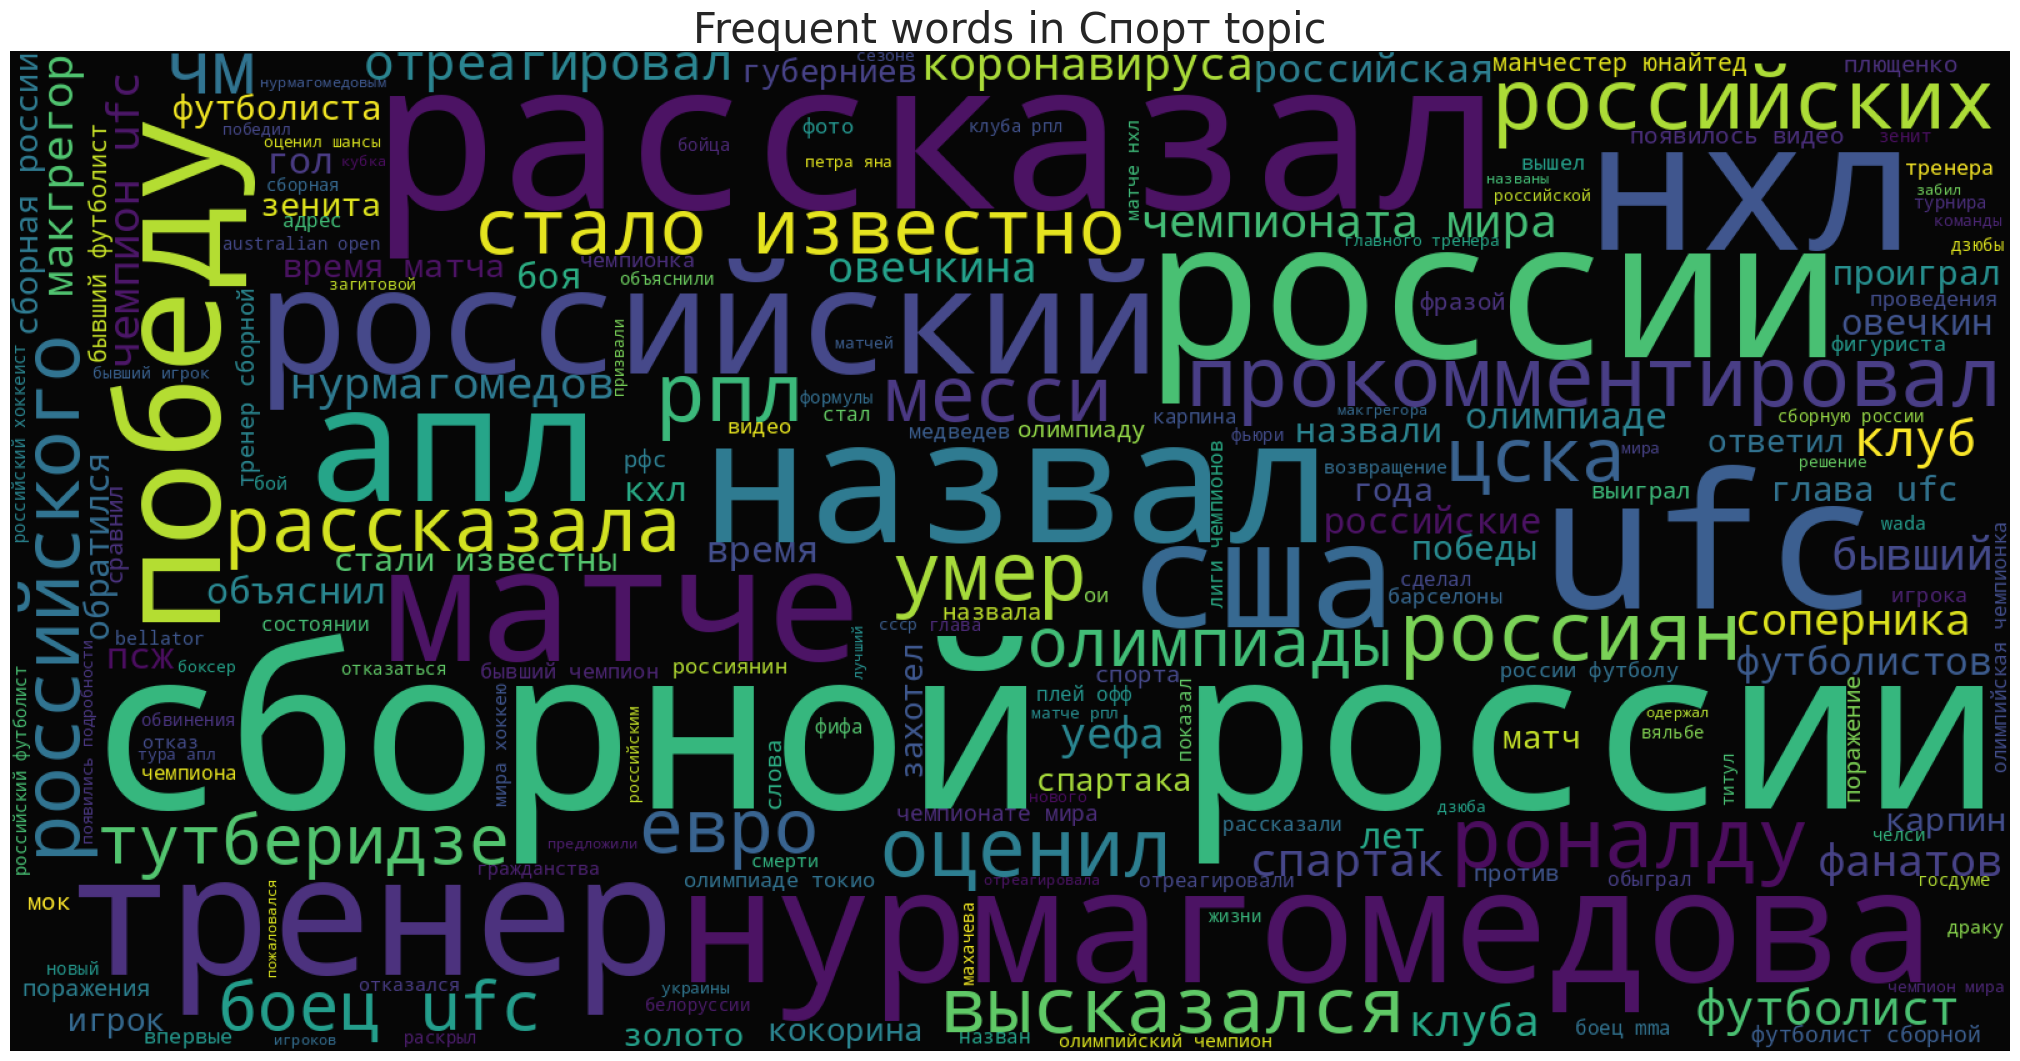

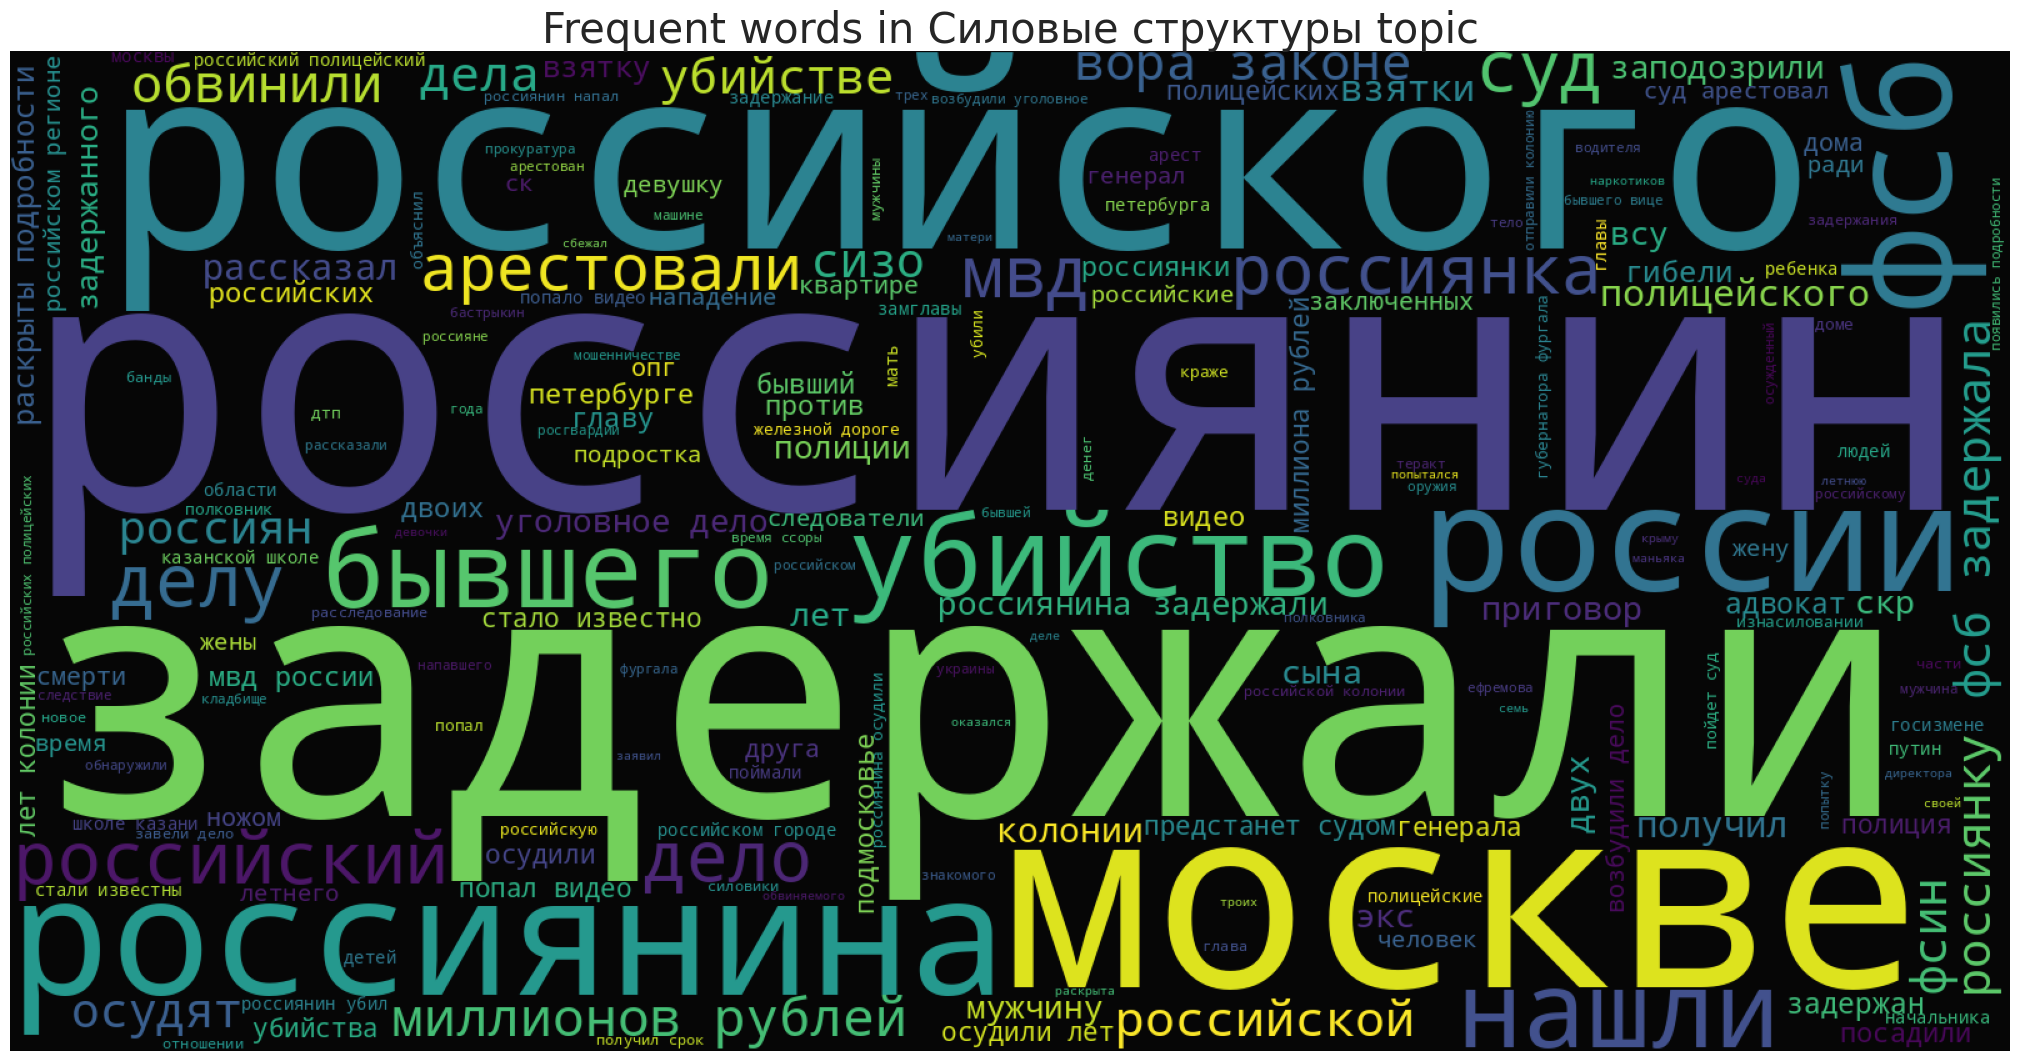

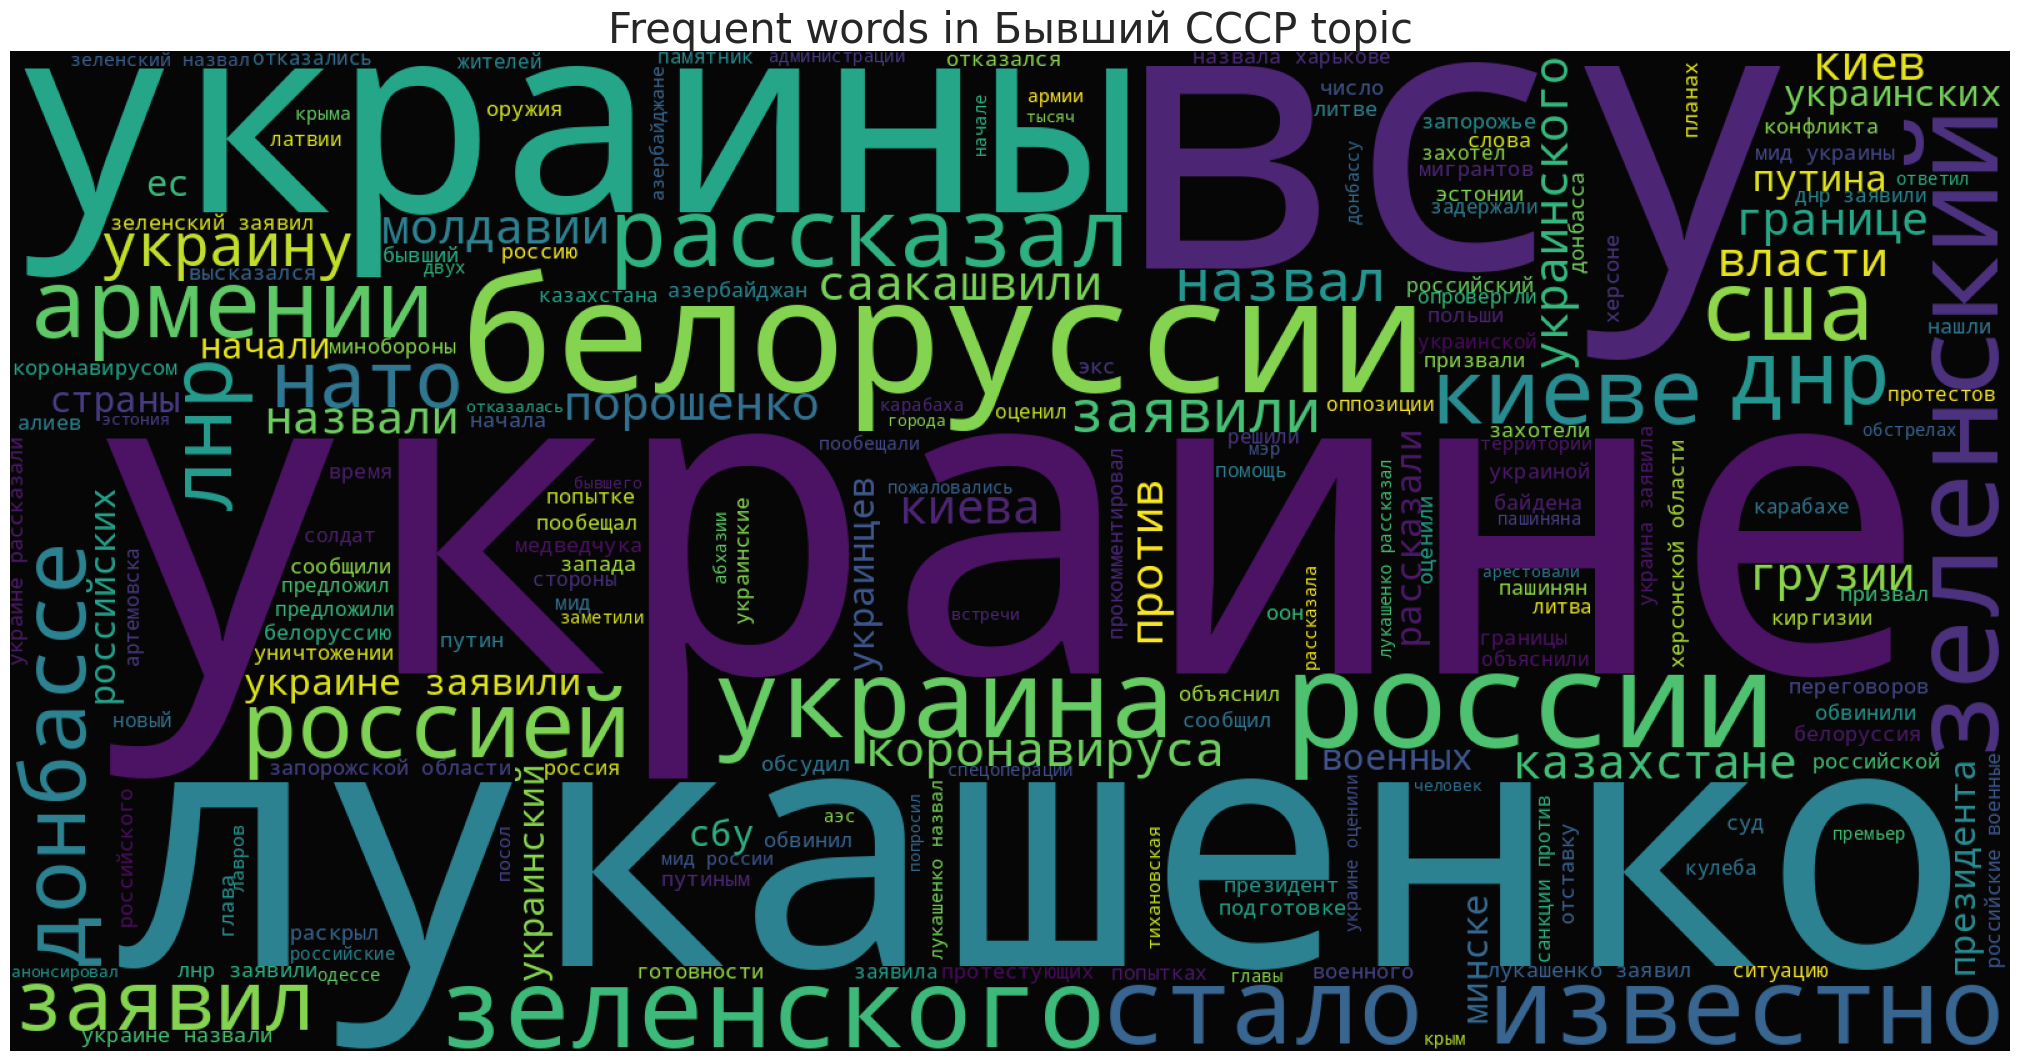

In [ ]:
for topic in df_pro.topic.unique():
    words = df_pro[df_pro.topic == topic].title.str.split(" ").explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

На сайте отсутствует счетчик просмотров или возможность комментирования. Но все равно ради интереса можно посмотреть распределение возраста статей. Тем более, что размах возрастов в нашем случае очень широк - от дня до 4 лет.

In [ ]:
df_pro["lifetime"] = df_pro["datetime"].apply(
    lambda x: (datetime.datetime.now() - x).total_seconds()
)
df_pro["lifetime"] = df_pro["lifetime"].apply(lambda x: divmod(x, 60)[0])

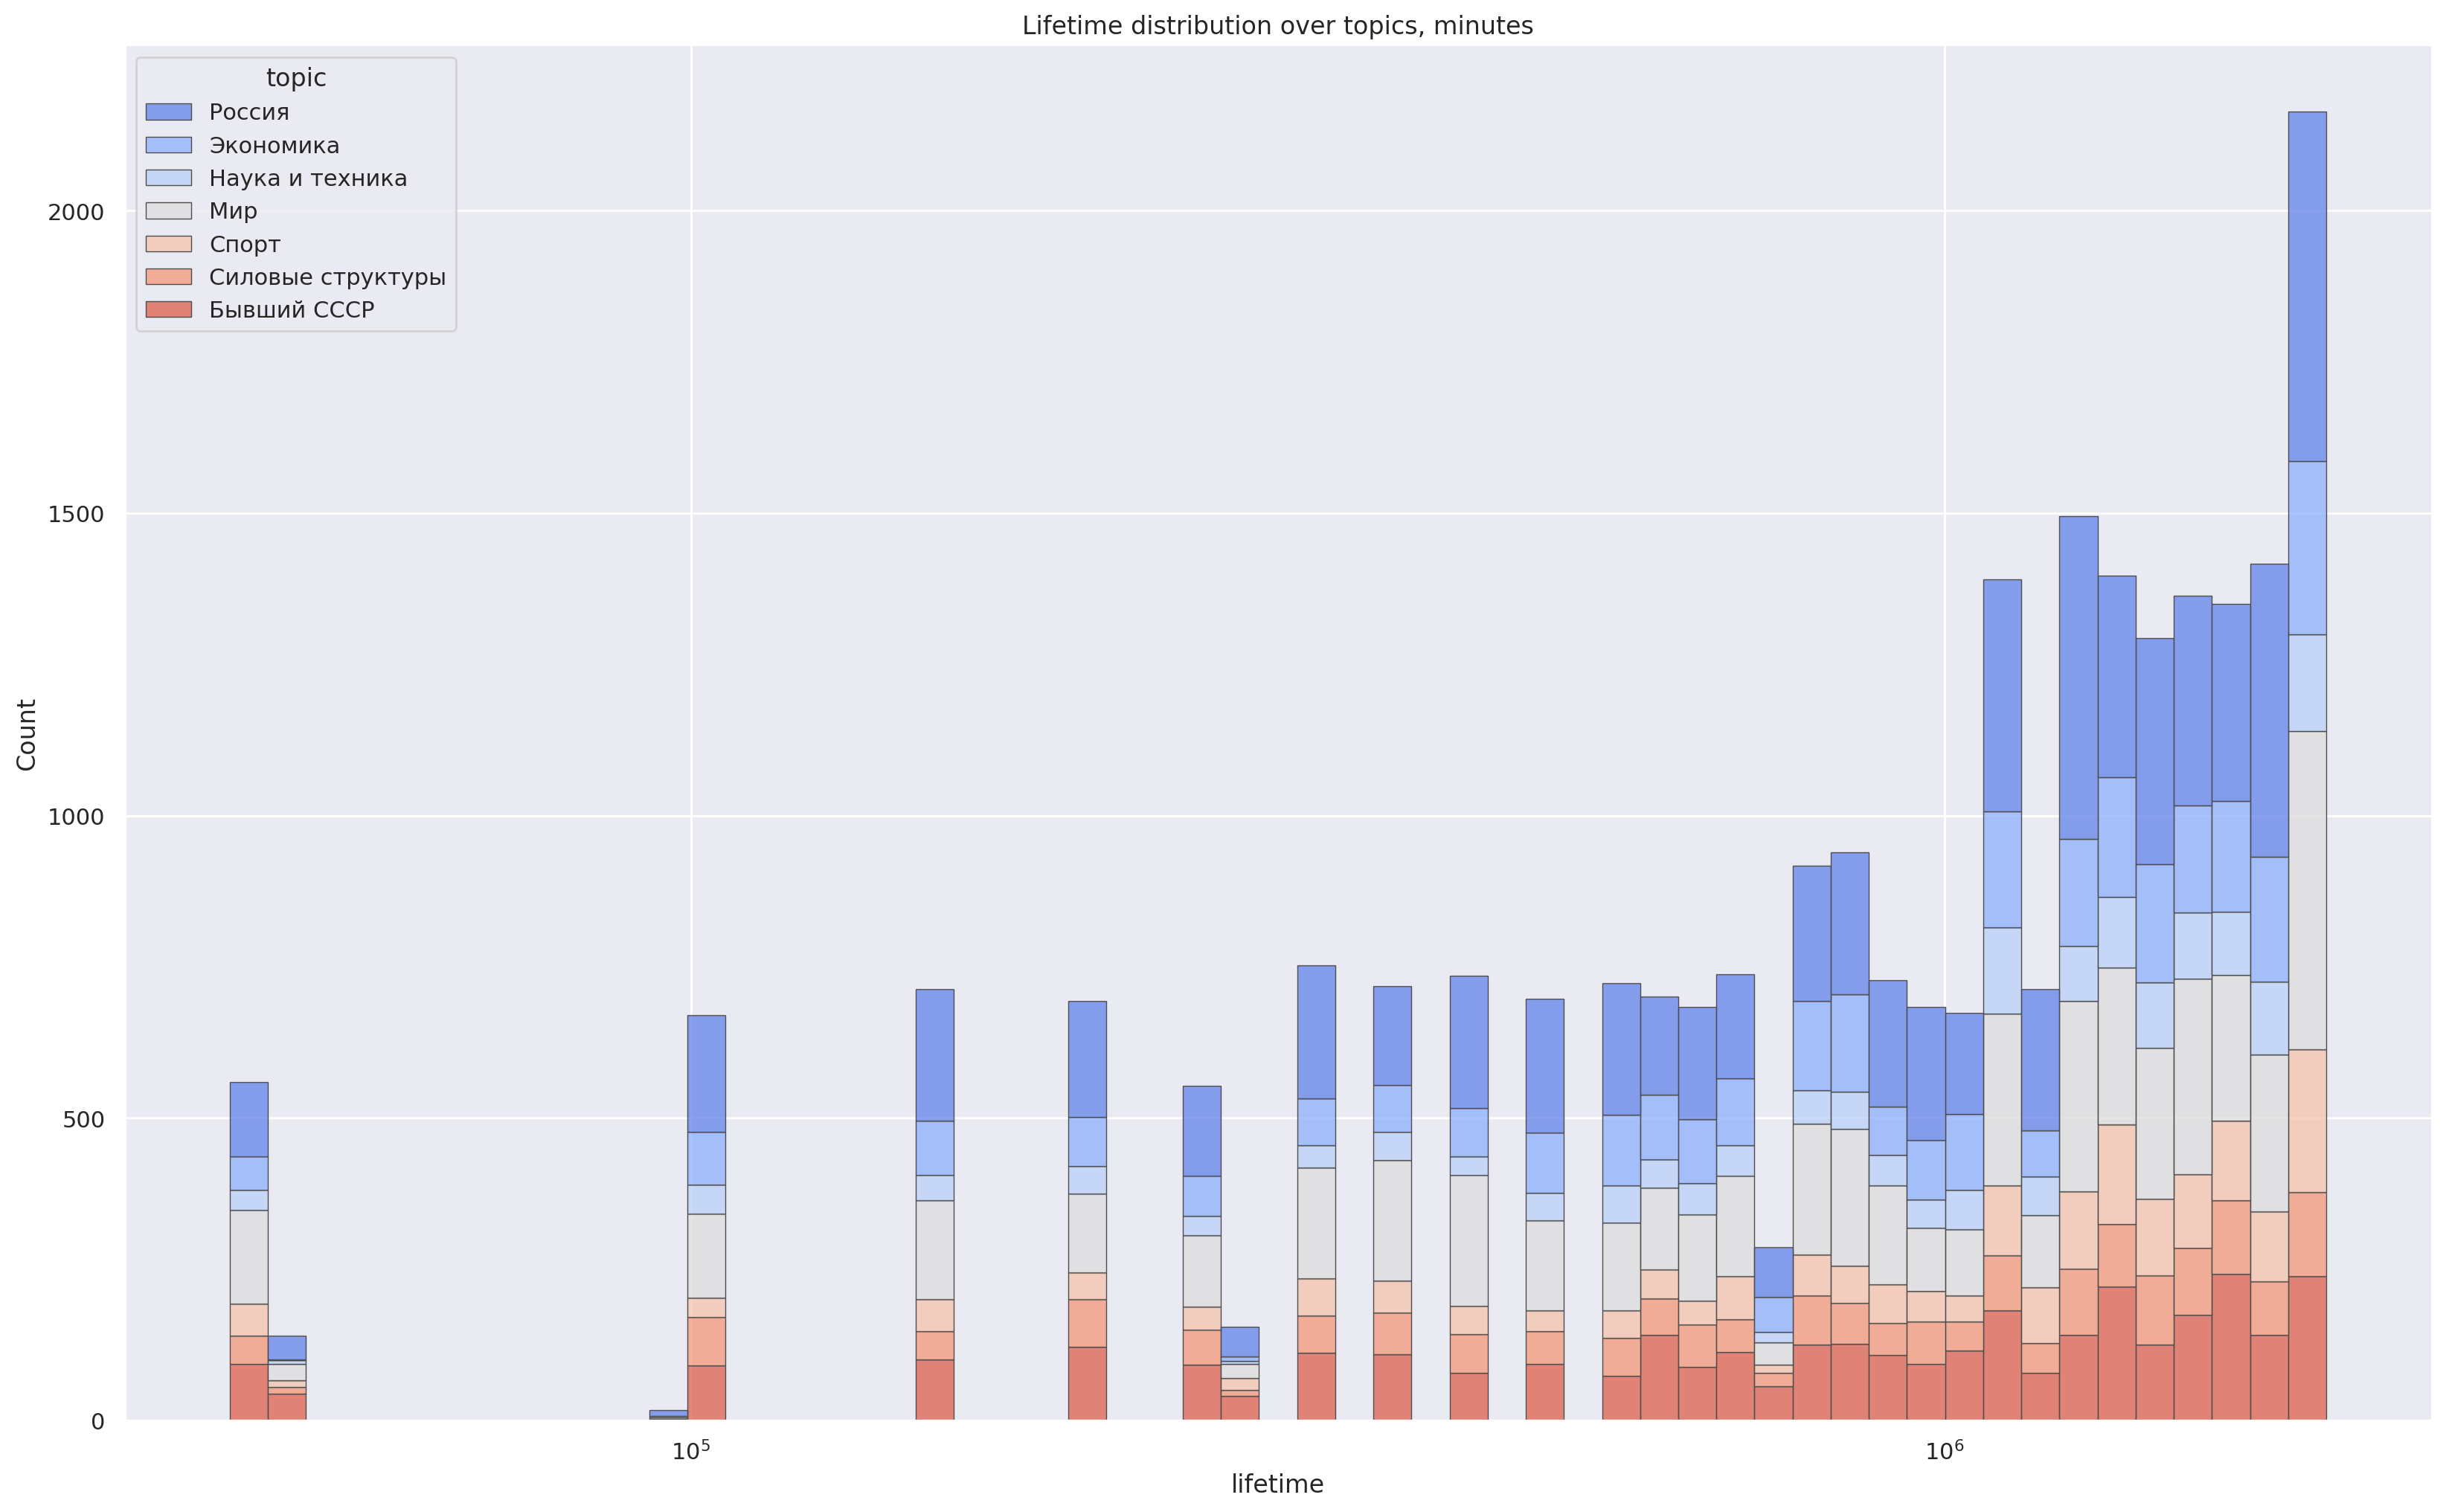

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df_pro,
    x="lifetime",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=0.5,
    log_scale=True,
)
axs.set_title("Lifetime distribution over topics, minutes");

Как и ожидалось, в датасете присутствуют как старые статьи, так и новые. И само распределение имеет довольно неоднозначную форму.

# Выводы

Итак, на данном этапе мы провели первичный анализ датасета. Статьи распределены по тематикам равномерно. Все новости относятся к временному диапозону от 2020 до 2023 года. Максимум статей приходится на 2021 год. Больше всего новостей пишется в январе и июле. В течение недели больше всего новостей в понедельник, вторник и воскресение

В среднем длина заголовка по всем категориям около 55-65 символов. Длина вступительного подзаголовка в среднем составляет 230 символов.

Во всех параметрах и для всех категорий наблюдается большое количество заметные выбросов в сторону большего количества символов.

Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

Поскольку мы работаем с текстами, на этом этапе пока не столь очевидно, какие данные и по какой причине стоит считать выбросами, а какие - особенностями конкретной тематики. Поэтому это мы оставим на следующие этапы работы над проектом.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3fc99ded-8c51-4f87-8ed8-1bcb9c249b20' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>